# Training models to predict next year's IFI tax for each French city

In this code, data is read and cleaned by recycling the code used in the data analysis: https://github.com/santiagopatinoserna/5YearFrenchWealthAnalysis.

Subsequently, the XGBoost model will be employed with the following hyperparameters (hp): #Best Parameters for XGBoost Model: {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.5}. Both the model and the selection of hp are detailed in this notebook: https://github.com/santiagopatinoserna/TensorFlow_Prediction_5YearFrench_IFI/blob/main/Script/Model_selection_ML_NN.ipynb. Here, seven different models were tested, with hp optimization within each model, and ultimately, the best model was selected based on six different scores and cross-validation of the results. The results were reviewed by the GEN AI chat GPT via its API, which selected the best model by examining the results and acting in the role of an expert data scientist.

In this code, the XGBoost model will be launched with the selected hp, and a 5-year prediction will be carried out for each of the cities. It is also observed that certain outlier cities cannot be predicted with this model, so a basic Prophet model will be used, based on the predictive variable and GPS coordinates, as well as the distance to the nearest neighboring city.

## Data loading / Cleaning

As mentioned earlier, in this section we construct the DataFrame that will be used in the model.

In [1]:
# ----------------------------------------------------------------------------
# Mounting Google Drive for Data Access in Google Colab Environment
# ----------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import os

# ----------------------------------------------------------------------------
# Constants
# ----------------------------------------------------------------------------
DATA_PATH = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'

# Data type definitions for each column during loading
DTYPE_DICT = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}

# Dictionary for column name harmonization
HARMONIZATION_DICT = {
    'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'
}

# ----------------------------------------------------------------------------
# Data Loading
# ----------------------------------------------------------------------------
ificom_files = [f for f in os.listdir(DATA_PATH) if f.startswith('ificom')]
df_ificom = pd.concat([pd.read_excel(os.path.join(DATA_PATH, file), header=0, skiprows=1, dtype=DTYPE_DICT).assign(filename=file)
                       for file in ificom_files], ignore_index=True)

# ----------------------------------------------------------------------------
# Data Cleaning and Processing
# ----------------------------------------------------------------------------
# Harmonizing column names
for col, alt_col in HARMONIZATION_DICT.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])
df_ificom.drop(columns=list(HARMONIZATION_DICT.values()), inplace=True)

# Unit conversion and column redundancy removal
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(
    df_ificom["patrimoine moyen en millions d'euros"] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(
    df_ificom["impôt moyen en milliers d'euros"] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Additional data processing
df_ificom['Year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)
df_ificom.rename(columns={
    'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File'
}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and finalize 'City' column
unique_grouped_sorted = pd.read_excel(os.path.join(DATA_PATH, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)

# Constants for path definitions
PATH_IN = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
PATH_OUT = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

# Incorporate GPS coordinates into the dataframe
df_coordinates_gps = (pd.read_csv(os.path.join(PATH_IN, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

# Save processed dataframe to file
df_ificom.to_csv(os.path.join(PATH_OUT, 'df_ificom.csv'), index=False)

# ----------------------------------------------------------------------------
# Machine Learning Preparations
# ----------------------------------------------------------------------------
# Library imports for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Data filtering for prediction model
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

# Removing duplicate entries
df_ificom_clean = df_ificom_clean.drop_duplicates(keep='first').reset_index(drop=True)

In [ ]:
'''import pandas as pd
import os

# Constants
DATA_PATH = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
DTYPE_DICT = {
    'Région': str, 'Départements': str, 'Code commune (INSEE)': str, 'Commune': str,
    'nombre de redevables': int, 'patrimoine moyen en €': int, 'impôt moyen en €': int,
    "patrimoine moyen en millions d'euros": float, "impôt moyen en milliers d'euros": float
}
HARMONIZATION_DICT = {
    'Départements': 'Département', 'Code commune (INSEE)': 'Code de la commune (INSEE)',
    'Commune': 'Nom de la commune', 'nombre de redevables': 'Nombre de redevables',
    'patrimoine moyen en €': 'Patrimoine moyen en €', 'impôt moyen en €': 'Impôt moyen en €'
}

# Load data
ificom_files = [f for f in os.listdir(DATA_PATH) if f.startswith('ificom')]
df_ificom = pd.concat([pd.read_excel(os.path.join(DATA_PATH, file), header=0, skiprows=1, dtype=DTYPE_DICT).assign(filename=file)
                       for file in ificom_files], ignore_index=True)

# Harmonize column names
for col, alt_col in HARMONIZATION_DICT.items():
    df_ificom[col] = df_ificom[col].fillna(df_ificom[alt_col])
df_ificom.drop(columns=list(HARMONIZATION_DICT.values()), inplace=True)

# Convert units and drop redundant columns
df_ificom['patrimoine moyen en €'] = df_ificom['patrimoine moyen en €'].fillna(
    df_ificom["patrimoine moyen en millions d'euros"] * 1_000_000)
df_ificom['impôt moyen en €'] = df_ificom['impôt moyen en €'].fillna(
    df_ificom["impôt moyen en milliers d'euros"] * 1_000)
df_ificom.drop(['patrimoine moyen en millions d\'euros', 'impôt moyen en milliers d\'euros'], axis=1, inplace=True)

# Extract and process additional data
df_ificom['Year'] = df_ificom['filename'].str.extract(r'-(\d{4})\.').astype(float)
df_ificom.rename(columns={
    'Région': 'Region', 'Départements': 'Department', 'Code commune (INSEE)': 'Commune_Code_INSEE', 'Commune': 'City',
    'nombre de redevables': 'Number_of_Taxpayers', 'patrimoine moyen en €': 'Average_Assets_in_Euro',
    'impôt moyen en €': 'Average_Tax_in_Euro', 'filename': 'Source_File'
}, inplace=True)
df_ificom['Commune_Code_INSEE'] = df_ificom['Commune_Code_INSEE'].str.replace(' ', '', regex=False)

# Merge and finalize 'City' column
unique_grouped_sorted = pd.read_excel(os.path.join(DATA_PATH, 'unique_grouped_sorted.xlsx'), dtype=str)[['Commune_Code_INSEE', 'Final_City']].drop_duplicates()
df_ificom = df_ificom.merge(unique_grouped_sorted, on='Commune_Code_INSEE', how='left')
df_ificom['City'] = df_ificom['City'].fillna(df_ificom['Final_City'])
df_ificom.drop(columns=['Final_City'], inplace=True)

# Constants
PATH_IN = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/DataIn'
PATH_OUT = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/TensorFlow_Prediction_5YearFrench_IFI/TensorFlow_Prediction_5YearFrench_IFI/Dataout'

# Add GPS coordinates to the dataframe
df_coordinates_gps = (pd.read_csv(os.path.join(PATH_IN, 'communes-departement-region.csv'),
                                  dtype={'code_commune_INSEE': str, 'latitude': float, 'longitude': float})
                      [['code_commune_INSEE', 'latitude', 'longitude']]
                      .rename(columns={'code_commune_INSEE': 'Commune_Code_INSEE'})
                      .assign(Commune_Code_INSEE=lambda df: df['Commune_Code_INSEE'].str.zfill(5)))

df_ificom = (df_ificom.merge(df_coordinates_gps, how='left', on='Commune_Code_INSEE')
             .assign(total_tax_per_city=lambda df: df['Average_Tax_in_Euro'] * df['Number_of_Taxpayers']))

df_ificom.to_csv(os.path.join(PATH_OUT, 'df_ificom.csv'), index=False)

# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Filter relevant data for prediction
df_ificom_clean = df_ificom.dropna(subset=['latitude', 'longitude', 'Year', 'total_tax_per_city'])

# Remove duplicates, retaining the first occurrence
df_ificom_clean = df_ificom_clean.drop_duplicates(keep='first').reset_index(drop=True)

# ----------------------------------------------------------------------------
# Feature Model Construction
# ----------------------------------------------------------------------------

In this section, we will construct the features that were identified as optimal
for the predictive model using XGBoost.



In [3]:
import numpy as np
import pandas as pd

# FEATURE 1: LAGGED DATA
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])
df_ificom_clean['total_tax_per_city_lag1'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# FEATURE 4: GENERAL STATISTICS
def compute_prior_statistics(row):
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({'mean': None, 'median': None, 'min': None, 'max': None})
    return pd.Series({'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()})

statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)

# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

for _, row1 in unique_cities.iterrows():
    for _, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])

# Convert unique_distances to numeric type
unique_distances = unique_distances.astype(float)

# Calculate the mean distances to the 10 nearest cities
mean_distances_to_10_nearest = {city: unique_distances.loc[city].nsmallest(11).iloc[1:].mean() for city in unique_cities['Commune_Code_INSEE']}
df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest)

In [ ]:
'''import numpy as np
import pandas as pd

# FEATURE 1: LAGGED DATA
df_ificom_clean = df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'])
df_ificom_clean['total_tax_per_city_lag1'] = df_ificom_clean.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# FEATURE 4: GENERAL STATISTICS
def compute_prior_statistics(row):
    prior_data = df_ificom_clean[(df_ificom_clean['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df_ificom_clean['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return pd.Series({'mean': None, 'median': None, 'min': None, 'max': None})
    return pd.Series({'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()})

statistics_df = df_ificom_clean.apply(compute_prior_statistics, axis=1)
df_ificom_clean = pd.concat([df_ificom_clean, statistics_df], axis=1)

# FEATURE 5: AVERAGE DISTANCE TO THE 10 NEAREST CITIES
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

unique_cities = df_ificom_clean.drop_duplicates(subset='Commune_Code_INSEE')[['latitude', 'longitude', 'Commune_Code_INSEE']]
unique_distances = pd.DataFrame(index=unique_cities['Commune_Code_INSEE'], columns=unique_cities['Commune_Code_INSEE'])

for _, row1 in unique_cities.iterrows():
    for _, row2 in unique_cities.iterrows():
        unique_distances.at[row1['Commune_Code_INSEE'], row2['Commune_Code_INSEE']] = haversine_distance(row1['latitude'], row1['longitude'], row2['latitude'], row2['longitude'])

# Convert unique_distances to numeric type
unique_distances = unique_distances.astype(float)

# Calculate the mean distances to the 10 nearest cities
mean_distances_to_10_nearest = {city: unique_distances.loc[city].nsmallest(11).iloc[1:].mean() for city in unique_cities['Commune_Code_INSEE']}
df_ificom_clean['mean_distance_to_10_nearest'] = df_ificom_clean['Commune_Code_INSEE'].map(mean_distances_to_10_nearest)



In [4]:
from sklearn.preprocessing import StandardScaler

# Reset the index for selected columns and drop the old index
df_ificom_clean = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers',
                                   'Average_Assets_in_Euro', 'Average_Tax_in_Euro', 'Source_File', 'Year', 'latitude',
                                   'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1', 'mean', 'median',
                                   'min', 'max', 'mean_distance_to_10_nearest']].reset_index(drop=True)

# Extract identity columns for each city
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define the features and the target variable
features = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']].fillna(0)
target = df_ificom_clean['total_tax_per_city']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
'''from sklearn.preprocessing import StandardScaler

# Reset the index of selected columns and drop the old index
df_ificom_clean = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City', 'Number_of_Taxpayers',
                                   'Average_Assets_in_Euro', 'Average_Tax_in_Euro', 'Source_File', 'Year', 'latitude',
                                   'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1', 'mean', 'median',
                                   'min', 'max', 'mean_distance_to_10_nearest']].reset_index(drop=True)

# Extract identity columns for each city
ID_df = df_ificom_clean[['Region', 'Department', 'Commune_Code_INSEE', 'City']]

# Define features and target variable
features = df_ificom_clean[['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
                            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']].fillna(0)
target = df_ificom_clean['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [5]:
def remove_outliers(df, column):
    """Remove outliers based on IQR for a specified column."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    outlier_communes = df.loc[
        (df[column] < lower_threshold) |
        (df[column] > upper_threshold),
        'Commune_Code_INSEE'
    ].unique()

    return df[~df['Commune_Code_INSEE'].isin(outlier_communes)].copy(), outlier_communes


def fill_na_values(df):
    """Fill NA values for numeric columns based on Commune_Code_INSEE groups."""
    df.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col] = df.groupby('Commune_Code_INSEE')[col].fillna(method='ffill')

    return df.dropna()


# Clean outliers for 'total_tax_per_city'
df_ificom_clean_outliers, outlier_communes = remove_outliers(df_ificom_clean, 'total_tax_per_city')

# Fill NA values
df_ificom_clean_outliers = fill_na_values(df_ificom_clean_outliers)


In [ ]:
'''def remove_outliers(df, column):
    """Remove outliers based on IQR for a specified column."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR

    outlier_communes = df.loc[
        (df[column] < lower_threshold) |
        (df[column] > upper_threshold),
        'Commune_Code_INSEE'
    ].unique()

    return df[~df['Commune_Code_INSEE'].isin(outlier_communes)].copy(), outlier_communes


def fill_na_values(df):
    """Fill NA values for numeric columns based on Commune_Code_INSEE groups."""
    df.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col] = df.groupby('Commune_Code_INSEE')[col].fillna(method='ffill')

    return df.dropna()


# Clean outliers for 'total_tax_per_city'
df_ificom_clean_outliers,outlier_communes = remove_outliers(df_ificom_clean, 'total_tax_per_city')

# Fill NA values
df_ificom_clean_outliers = fill_na_values(df_ificom_clean_outliers)


In [ ]:
'''
#Separate features for the trainiing model and the target variable for training model

features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']

X = df_ificom_clean_outliers[features]
y = df_ificom_clean_outliers['total_tax_per_city']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
'''


"\n#Separate features for the trainiing model and the target variable for training model\n\nfeatures = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',\n            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']\n\nX = df_ificom_clean_outliers[features]\ny = df_ificom_clean_outliers['total_tax_per_city']\n\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\ny_scaled = scaler.fit_transform(y.values.reshape(-1, 1))\n"

# ----------------------------------------------------------------------------
# Constructing the DataFrame for Predictions
# ----------------------------------------------------------------------------


In this section, we build the DataFrame for the data that will be predicted.

The model and its subsequent predictions will exclude cities with outlier values.
Incorporating these outliers would negatively impact the model's performance for other cities.
Moreover, using a model trained without these outliers to predict their values would yield highly inaccurate results.



In [6]:
"""
Organizing and Preparing Data for Model Training and Prediction:

1. Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'.
2. Determine the latest year recorded for each 'Commune_Code_INSEE'.
3. Construct a new DataFrame for predictions for the year following the most recent one.
   These entries will have the `to_be_predicted` flag set to True.
4. Combine the original DataFrame with the prediction DataFrame.
"""

# Identify 'Commune_Code_INSEE' values in df_ificom_clean that aren't in df_ificom_clean_outliers.
# These codes are flagged for risky forecasts.
missing_insee_codes = df_ificom_clean.loc[~df_ificom_clean['Commune_Code_INSEE'].isin(df_ificom_clean_outliers['Commune_Code_INSEE']), 'Commune_Code_INSEE'].unique()

# Step 1: Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'
df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

# Step 2: Identify the most recent year for each 'Commune_Code_INSEE'
latest_years = df_ificom_clean.groupby('Commune_Code_INSEE')['Year'].max()

# Step 3: Prepare a DataFrame for predictions for the year following the latest recorded year
to_be_predicted_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True}
                        for commune, year in latest_years.items()]
df_to_be_predicted = pd.DataFrame(to_be_predicted_data)

# Introduce the 'to_be_predicted' column to df_ificom_clean with default value as False
df_ificom_clean['to_be_predicted'] = False

# Step 4: Merge df_ificom_clean and df_to_be_predicted
df_ificom_clean_to_be_predicted = pd.concat([df_ificom_clean, df_to_be_predicted], ignore_index=True)


In [ ]:
'''
"""
Organize and prepare data for model training and prediction:

1. The DataFrame is organized by 'Commune_Code_INSEE' and 'Year'.
2. Determine the latest year recorded for each 'Commune_Code_INSEE'.
3. Create a new DataFrame to predict the values for the year following the most recent one.
   These entries are flagged with `to_be_predicted` set to True.
4. Combine the original DataFrame and the prediction DataFrame.
"""

# Encuentra los valores de Commune_Code_INSEE en df_ificom_clean que no están en df_ificom_clean_outliers
#These codes should be taged as riski forecast
missing_insee_codes = df_ificom_clean[~df_ificom_clean['Commune_Code_INSEE'].isin(df_ificom_clean_outliers['Commune_Code_INSEE'])]['Commune_Code_INSEE'].unique()

# Step 1: Sort the DataFrame by 'Commune_Code_INSEE' and 'Year'
df_ificom_clean.sort_values(by=['Commune_Code_INSEE', 'Year'], inplace=True)

# Step 2: Identify the most recent year for each 'Commune_Code_INSEE'
latest_years = df_ificom_clean.groupby('Commune_Code_INSEE')['Year'].max()

# Step 3: Construct a new DataFrame for the year following the latest recorded year
to_be_predicted_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True}
                        for commune, year in latest_years.items()]
df_to_be_predicted = pd.DataFrame(to_be_predicted_data)

# Add the 'to_be_predicted' column to df_ificom_clean, defaulting to False
df_ificom_clean['to_be_predicted'] = False

# Step 4: Combine df_ificom_clean and df_to_be_predicted
df_ificom_clean_to_be_predicted = pd.concat([df_ificom_clean, df_to_be_predicted], ignore_index=True)

In [8]:
# ----------------------------------------------------------------------------
# Filling Static Variable Values for 'to_be_predicted' Rows
# ----------------------------------------------------------------------------

"""
For rows marked 'to_be_predicted', we fill static variable values using data from the previous year.
This ensures consistency and provides necessary information for predictions.
"""

df_sorted = df_ificom_clean_to_be_predicted.sort_values(by=["Commune_Code_INSEE", "Year"])

for i, row in df_sorted.iterrows():
    if row["to_be_predicted"]:
        prev_row = df_sorted.loc[
            (df_sorted["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) &
            (df_sorted["Year"] == row["Year"] - 1)
        ].iloc[0]

        for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
            df_sorted.at[i, col] = prev_row[col]

# ----------------------------------------------------------------------------
# Feature 1: Lagged Data - Constructing the Feature for Future Years
# ----------------------------------------------------------------------------
# Generate a single lag column based on the original data
df_ificom_clean_to_be_predicted['total_tax_per_city_lag1'] = df_ificom_clean_to_be_predicted.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# Reset the index to its original order
df_ificom_clean_to_be_predicted.reset_index(inplace=True)

# ----------------------------------------------------------------------------
# Feature 4: General Statistics
# ----------------------------------------------------------------------------
# Compute aggregate statistics using historical data to prevent data leakage.

def compute_prior_statistics(row):
    prior_data = df_ificom_clean_to_be_predicted[
        (df_ificom_clean_to_be_predicted['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean_to_be_predicted['Year'] < row['Year'])
    ]['total_tax_per_city']

    if prior_data.empty:
        return pd.Series({
            'mean': np.nan,
            'median': np.nan,
            'min': np.nan,
            'max': np.nan
        })

    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max()
    })

statistics_df = df_ificom_clean_to_be_predicted.apply(compute_prior_statistics, axis=1)
df_ificom_clean_to_be_predicted[['mean', 'median', 'min', 'max']] = statistics_df


# ----------------------------------------------------------------------------
# Preparing Data for Predictions
# ----------------------------------------------------------------------------
# Extract rows marked 'to_be_predicted' and define feature set

features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']

X_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][features]
ID_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][['Commune_Code_INSEE', 'Year']]

In [ ]:
'''
#Fill static variable values for 'to_be_predicted' rows using the previous year's data.

df_sorted = df_ificom_clean_to_be_predicted.sort_values(by=["Commune_Code_INSEE", "Year"])

for i, row in df_sorted.iterrows():
    if row["to_be_predicted"]:
        prev_row = df_sorted[(df_sorted["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) &
                             (df_sorted["Year"] == row["Year"] - 1)].iloc[0]

        for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
            df_sorted.at[i, col] = prev_row[col]

# FEATURE 1: LAGGED DATA - building the Feature for futur years
# Generating a single lag column (as per the original range)
df_ificom_clean_to_be_predicted['total_tax_per_city_lag1'] = df_ificom_clean_to_be_predicted.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# Reset the index to its original state
df_ificom_clean_to_be_predicted.reset_index(inplace=True)

#FEATURE 4: GENERAL STATISTICS
#Compute aggregate statistics using historical data to avoid data leakage.

def compute_prior_statistics(row):
    prior_data = df_ificom_clean_to_be_predicted[
        (df_ificom_clean_to_be_predicted['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean_to_be_predicted['Year'] < row['Year'])
    ]['total_tax_per_city']

    if prior_data.empty:
        return pd.Series({'mean': None, 'median': None, 'min': None, 'max': None})

    return pd.Series({
        'mean': prior_data.mean(),
        'median': prior_data.median(),
        'min': prior_data.min(),
        'max': prior_data.max()
    })

statistics_df = df_ificom_clean_to_be_predicted.apply(compute_prior_statistics, axis=1)
df_ificom_clean_to_be_predicted[['mean', 'median', 'min', 'max']] = statistics_df

#Pepare data for predictions once the model is trained.
# Select rows marked 'to_be_predicted' and extract features
features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1',
            'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']

X_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][features]
ID_tobe_predicted = df_ificom_clean_to_be_predicted[df_ificom_clean_to_be_predicted['to_be_predicted']][['Commune_Code_INSEE', 'Year']]


## Training model without outliers

In this section, we'll train a predictive model using data that has been cleaned of outliers. By eliminating extreme values that can skew the data, we aim to improve the accuracy and robustness of the model. This approach ensures that the model is influenced primarily by the general trend of the data rather than extreme, possibly anomalous, values.

In [17]:
# Preparing and Scaling Data for Modeling
selected_features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean',
                     'median', 'min', 'max', 'mean_distance_to_10_nearest']

X = df_ificom_clean_outliers[selected_features]
y = df_ificom_clean_outliers['total_tax_per_city']

# Scaling the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Initializing and Training the XGBoost Model with Optimal Hyperparameters
import xgboost as xgb

# Optimal Hyperparameters for XGBoost Model
optimal_params = {
    'colsample_bytree': 0.4,
    'gamma': 0,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 250,
    'subsample': 0.5
}

# Training the XGBoost Model
xgb_regressor = xgb.XGBRegressor(**optimal_params)
xgb_regressor.fit(X_scaled, y_scaled)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
'''#Prepare and scale data for modeling.
features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean',
            'median', 'min', 'max', 'mean_distance_to_10_nearest']

X = df_ificom_clean_outliers[features]
y = df_ificom_clean_outliers['total_tax_per_city']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

#Initialize and train XGBoost model with best hyperparameters.
import xgboost as xgb

# Best hyperparameters for XGBoost Model
best_params = {
    'colsample_bytree': 0.4,
    'gamma': 0,
    'learning_rate': 0.05,
    'max_depth': 3,
    'n_estimators': 250,
    'subsample': 0.5
}

# Train XGBoost model
xgb_regressor = xgb.XGBRegressor(**best_params)
xgb_regressor.fit(X_scaled, y_scaled)

## Predicting values for the first Year + 1

In this section, we'll use the trained model to forecast values for the year immediately following the latest year in our dataset. This prediction aims to provide insights into potential tax outcomes for the subsequent year based on the established patterns and trends in the data.

In [18]:
# Scale the DataFrame prepared for prediction
X_tobe_predicted_scaled = scaler.transform(X_tobe_predicted)

# Generate predictions
y_pred_scaled = xgb_regressor.predict(X_tobe_predicted_scaled)

# Convert the scaled predictions back to their original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Create a DataFrame with the predicted values
predictions_df = pd.DataFrame({
    'Commune_Code_INSEE': ID_tobe_predicted['Commune_Code_INSEE'].values,
    'Predicted_total_tax_per_city': y_pred.ravel()
})

# Merge the features and predictions into a new DataFrame for looped predictions
df_predicted = pd.concat([X_tobe_predicted.reset_index(drop=True), predictions_df], axis=1)

# Function to update a base DataFrame using values from an update DataFrame
def replace_values_using_iloc(df_base, df_update):
    for _, row in df_update.iterrows():
        # Locate the corresponding row in the base DataFrame
        row_index = df_base[
            (df_base['Year'] == row['Year']) &
            (df_base['Commune_Code_INSEE'] == row['Commune_Code_INSEE'])
        ].index[0]

        # Replace values in the base DataFrame using data from the update DataFrame
        for col in df_update.columns:
            if col not in ['Year', 'Commune_Code_INSEE']:
                col_index = df_base.columns.get_loc(col)
                df_base.iloc[row_index, col_index] = row[col]

    return df_base

# Update the main DataFrame using the predicted values
df_ificom_clean_to_be_predictedV2 = replace_values_using_iloc(df_ificom_clean_to_be_predicted.copy(), df_predicted.rename(columns={'Predicted_total_tax_per_city':'total_tax_per_city'}))

# Label rows based on whether they contain predicted values
df_ificom_clean_to_be_predictedV2['predicted'] = df_ificom_clean_to_be_predictedV2['to_be_predicted'].apply(lambda x: True if x else False)
df_ificom_clean_to_be_predictedV2['to_be_predicted'] = False


In [ ]:
'''#Scaling the DF to be predicted
X_tobe_predicted_scaled = scaler.transform(X_tobe_predicted)

#Predicting the values
y_pred_scaled = xgb_regressor.predict(X_tobe_predicted_scaled)

#Inverse scaling
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

predictions_df = pd.DataFrame({
    'Commune_Code_INSEE': ID_tobe_predicted['Commune_Code_INSEE'].values,
    'Predicted_total_tax_per_city': y_pred.ravel()
})

#Saving prediction in a new DF to make a boucle prediction
df_predicted=pd.concat([X_tobe_predicted.reset_index(drop=True), predictions_df], axis=1)

#Saving the news values in a DataFrame that will be used to make the prediction for the next year(in a cycle )
def replace_values_using_iloc(df_base, df_update):
    for _, row in df_update.iterrows():
        # Find the row index in df_base based on Year and Commune_Code_INSEE
        row_index = df_base[
            (df_base['Year'] == row['Year']) &
            (df_base['Commune_Code_INSEE'] == row['Commune_Code_INSEE'])
        ].index[0]

        # Replace values for the desired columns using iloc
        for col in df_update.columns:
            if col not in ['Year', 'Commune_Code_INSEE']:
                col_index = df_base.columns.get_loc(col)
                df_base.iloc[row_index, col_index] = row[col]

    return df_base

# Update df_ificom_clean_to_be_predicted using values from df_predicted
df_ificom_clean_to_be_predictedV2=replace_values_using_iloc(df_ificom_clean_to_be_predicted.copy(), df_predicted.rename(columns={'Predicted_total_tax_per_city':'total_tax_per_city'}))

# Add the 'predicted' column based on the 'to_be_predicted' column
df_ificom_clean_to_be_predictedV2['predicted'] = df_ificom_clean_to_be_predictedV2['to_be_predicted'].apply(lambda x: True if x else False)
df_ificom_clean_to_be_predictedV2['to_be_predicted'] = False'''

### 5-Year Predictive Forecasting

Using the trained XGBoost model, this code predicts tax values for each city over the next five years. Predictions are made year-by-year, updating the dataset with each new forecasted value.

In [19]:
def get_data_for_next_year(df):
    """
    Get data for the next year based on the most recent year's data.
    """
    df_sorted = df.sort_values(by=['Commune_Code_INSEE', 'Year'])
    latest_years = df_sorted.groupby('Commune_Code_INSEE')['Year'].max()

    next_year_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True} for commune, year in latest_years.items()]
    return pd.DataFrame(next_year_data)

def fill_values_from_previous_year(df):
    """
    Fill static values using data from the previous year.
    """
    for i, row in df.iterrows():
        if row["to_be_predicted"]:
            prev_row = df[(df["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) & (df["Year"] == row["Year"] - 1)].iloc[0]
            for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
                df.at[i, col] = prev_row[col]
    return df

def append_lagged_data(df):
    """
    Append lagged data for the 'total_tax_per_city' column.
    """
    col_name = 'total_tax_per_city_lag1'
    df[col_name] = df.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)
    return df

def compute_statistics_for_previous_data(row, df):
    """
    Compute statistics using data from previous years.
    """
    prior_data = df[(df['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return {'mean': None, 'median': None, 'min': None, 'max': None}
    else:
        return {'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()}

def append_general_statistics(df):
    """
    Append general statistics to the dataframe.
    """
    statistics_df = df.apply(lambda row: compute_statistics_for_previous_data(row, df), axis=1, result_type='expand')
    df[['mean', 'median', 'min', 'max']] = statistics_df[['mean', 'median', 'min', 'max']]
    return df

def perform_prediction_with_xgboost(df, scaler, xgb_regressor, y_scaler):
    """
    Use the XGBoost model to perform predictions.
    """
    features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']
    X = df[df['to_be_predicted']==True][features]
    X_scaled = scaler.transform(X)
    y_pred_scaled = xgb_regressor.predict(X_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    return y_pred

def incorporate_predictions_into_dataframe(df, y_pred):
    """
    Incorporate the predicted values into the main dataframe.
    """
    df.loc[df['to_be_predicted'], 'total_tax_per_city'] = y_pred.ravel()
    df['predicted'] = df['to_be_predicted'].copy()
    df['to_be_predicted'] = False
    df = df.drop(columns=[col for col in ['level_0', 'index'] if col in df.columns], errors='ignore')
    return df

for _ in range(4):
    # Add rows for the next year's predictions
    df_next_year = get_data_for_next_year(df_ificom_clean_to_be_predictedV2)
    df_ificom_clean_to_be_predictedV2 = pd.concat([df_ificom_clean_to_be_predictedV2, df_next_year], ignore_index=True).sort_values(by=["Commune_Code_INSEE", "Year"])

    # Fill values using data from the previous year
    df_ificom_clean_to_be_predictedV2 = fill_values_from_previous_year(df_ificom_clean_to_be_predictedV2)

    # Add lagged data
    df_ificom_clean_to_be_predictedV2 = append_lagged_data(df_ificom_clean_to_be_predictedV2)

    # Add statistics
    df_ificom_clean_to_be_predictedV2 = append_general_statistics(df_ificom_clean_to_be_predictedV2)

    # Predict using XGBoost
    y_pred = perform_prediction_with_xgboost(df_ificom_clean_to_be_predictedV2, scaler, xgb_regressor, y_scaler)

    # Incorporate predictions into the dataframe
    df_ificom_clean_to_be_predictedV2 = incorporate_predictions_into_dataframe(df_ificom_clean_to_be_predictedV2, y_pred)

df_ificom_clean_to_be_predictedV2.loc[df_ificom_clean_to_be_predictedV2['Number_of_Taxpayers'].isna(), 'predicted'] = True


In [ ]:
'''def get_next_year_data(df):
    df_sorted = df.sort_values(by=['Commune_Code_INSEE', 'Year'])
    latest_years = df_sorted.groupby('Commune_Code_INSEE')['Year'].max()

    next_year_data = [{'Commune_Code_INSEE': commune, 'Year': year + 1, 'to_be_predicted': True} for commune, year in latest_years.items()]
    return pd.DataFrame(next_year_data)

def copy_static_values(df):
    for i, row in df.iterrows():
        if row["to_be_predicted"]:
            prev_row = df[(df["Commune_Code_INSEE"] == row["Commune_Code_INSEE"]) & (df["Year"] == row["Year"] - 1)].iloc[0]
            for col in ["Region", "Department", "City", "latitude", "longitude", "mean_distance_to_10_nearest"]:
                df.at[i, col] = prev_row[col]
    return df

def add_lagged_data(df):
    col_name = 'total_tax_per_city_lag1'
    df[col_name] = df.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)
    return df

def compute_prior_statistics(row, df):
    prior_data = df[(df['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) & (df['Year'] < row['Year'])]['total_tax_per_city']
    if prior_data.empty:
        return {'mean': None, 'median': None, 'min': None, 'max': None}
    else:
        return {'mean': prior_data.mean(), 'median': prior_data.median(), 'min': prior_data.min(), 'max': prior_data.max()}

def add_general_statistics(df):
    statistics_df = df.apply(lambda row: compute_prior_statistics(row, df), axis=1, result_type='expand')
    df[['mean', 'median', 'min', 'max']] = statistics_df[['mean', 'median', 'min', 'max']]
    return df

def predict_with_xgboost(df, scaler, xgb_regressor, y_scaler):
    features = ['Year', 'latitude', 'longitude', 'total_tax_per_city_lag1', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']
    X = df[df['to_be_predicted']==True][features]
    X_scaled = scaler.transform(X)
    y_pred_scaled = xgb_regressor.predict(X_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    return y_pred

def update_predictions(df, y_pred):
    df.loc[df['to_be_predicted'], 'total_tax_per_city'] = y_pred.ravel()
    df['predicted'] = df['to_be_predicted'].copy()
    df['to_be_predicted'] = False
    df = df.drop(columns=[col for col in ['level_0', 'index'] if col in df.columns], errors='ignore')
    return df

for _ in range(4):
    # Add next year's rows for prediction
    df_next_year = get_next_year_data(df_ificom_clean_to_be_predictedV2)
    df_ificom_clean_to_be_predictedV2 = pd.concat([df_ificom_clean_to_be_predictedV2, df_next_year], ignore_index=True).sort_values(by=["Commune_Code_INSEE", "Year"])

    # Copy static values from previous year
    df_ificom_clean_to_be_predictedV2 = copy_static_values(df_ificom_clean_to_be_predictedV2)

    # Add lagged data as a feature
    df_ificom_clean_to_be_predictedV2 = add_lagged_data(df_ificom_clean_to_be_predictedV2)

    # Add general statistics as features
    df_ificom_clean_to_be_predictedV2 = add_general_statistics(df_ificom_clean_to_be_predictedV2)

    # Predict using XGBoost
    y_pred = predict_with_xgboost(df_ificom_clean_to_be_predictedV2, scaler, xgb_regressor, y_scaler)

    # Update predictions in the dataframe
    df_ificom_clean_to_be_predictedV2 = update_predictions(df_ificom_clean_to_be_predictedV2, y_pred)

df_ificom_clean_to_be_predictedV2.loc[df_ificom_clean_to_be_predictedV2['Number_of_Taxpayers'].isna(), 'predicted'] = True


#### Graph results

This visualization showcases the prediction outcomes for a subset of 10 cities.
It's important to note that these cities were randomly chosen and do not include any outliers.





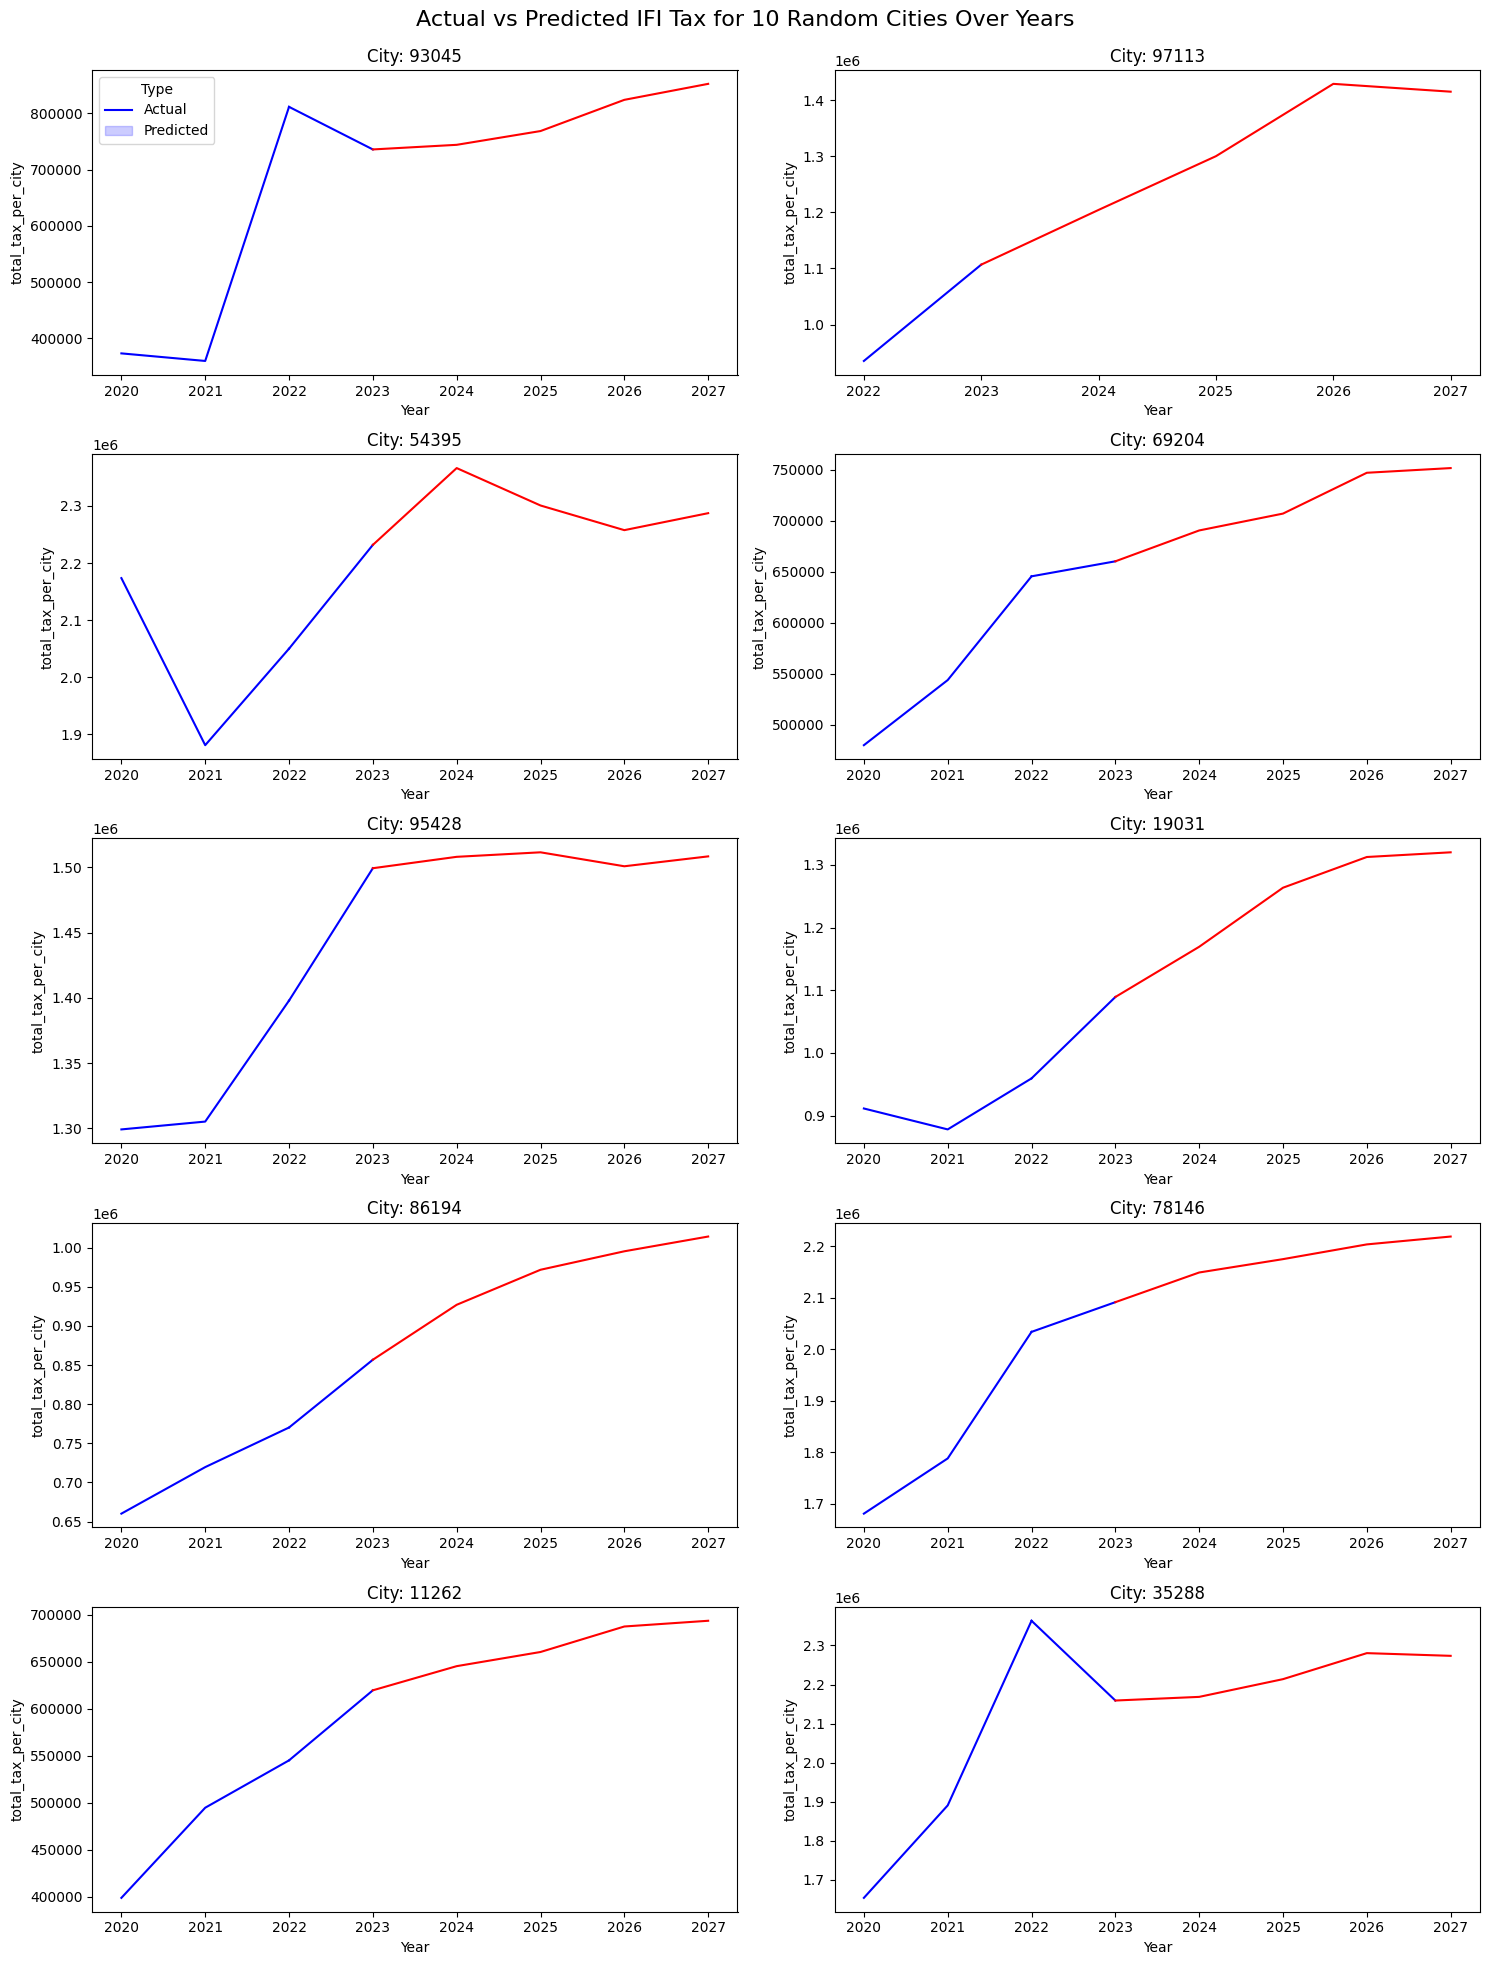

In [21]:
#### Visualizing Prediction Results for IFI Tax

# This visualization presents the actual vs. predicted IFI tax for 10 randomly selected cities over the years.
# The blue line represents the actual data while the red line shows the predicted values.
# It's essential to recognize that the cities chosen for this illustration do not include any outliers.

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the relative growth rate for each city.
growth_rates = {}
for city in df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].drop_duplicates():
    city_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]
    growth_rates[city] = (final_value - initial_value) / initial_value

growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# Exclude cities that are in outlier_communes
filtered_growth_rates_df = growth_rates_df[~growth_rates_df['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Randomly select 10 cities from the filtered data.
random_10_cities = filtered_growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 3. Plot these 10 cities with a continuous line that changes color.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, city in enumerate(random_10_cities):
    row, col = divmod(idx, 2)
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    # Plot all the data where predicted = False
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Connect the last point where predicted = False to the first point where predicted = True
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')

    # Plot all the data where predicted = True
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Actual', 'Predicted'])
plt.suptitle("Actual vs Predicted IFI Tax for 10 Random Cities Over Years", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the space to fit the suptitle
plt.show()


In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute the relative growth rate for each city.
growth_rates = {}
for city in df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].drop_duplicates():
    city_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]
    growth_rates[city] = (final_value - initial_value) / initial_value

growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# Excluir las ciudades que están en outlier_communes
filtered_growth_rates_df = growth_rates_df[~growth_rates_df['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Seleccionar 10 ciudades aleatorias de los datos filtrados.
random_10_cities = filtered_growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 3. Graficar estas 10 ciudades con una línea continua que cambia de color.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, city in enumerate(random_10_cities):
    row, col = divmod(idx, 2)
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    # Graficar todos los datos donde predicted = False
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Conectar el último punto donde predicted = False con el primer punto donde predicted = True
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')

    # Graficar todos los datos donde predicted = True
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'Ciudad: {city}')

axes[0, 0].legend(title='Tipo', labels=['Real', 'Predicho'])
plt.tight_layout()
plt.show()


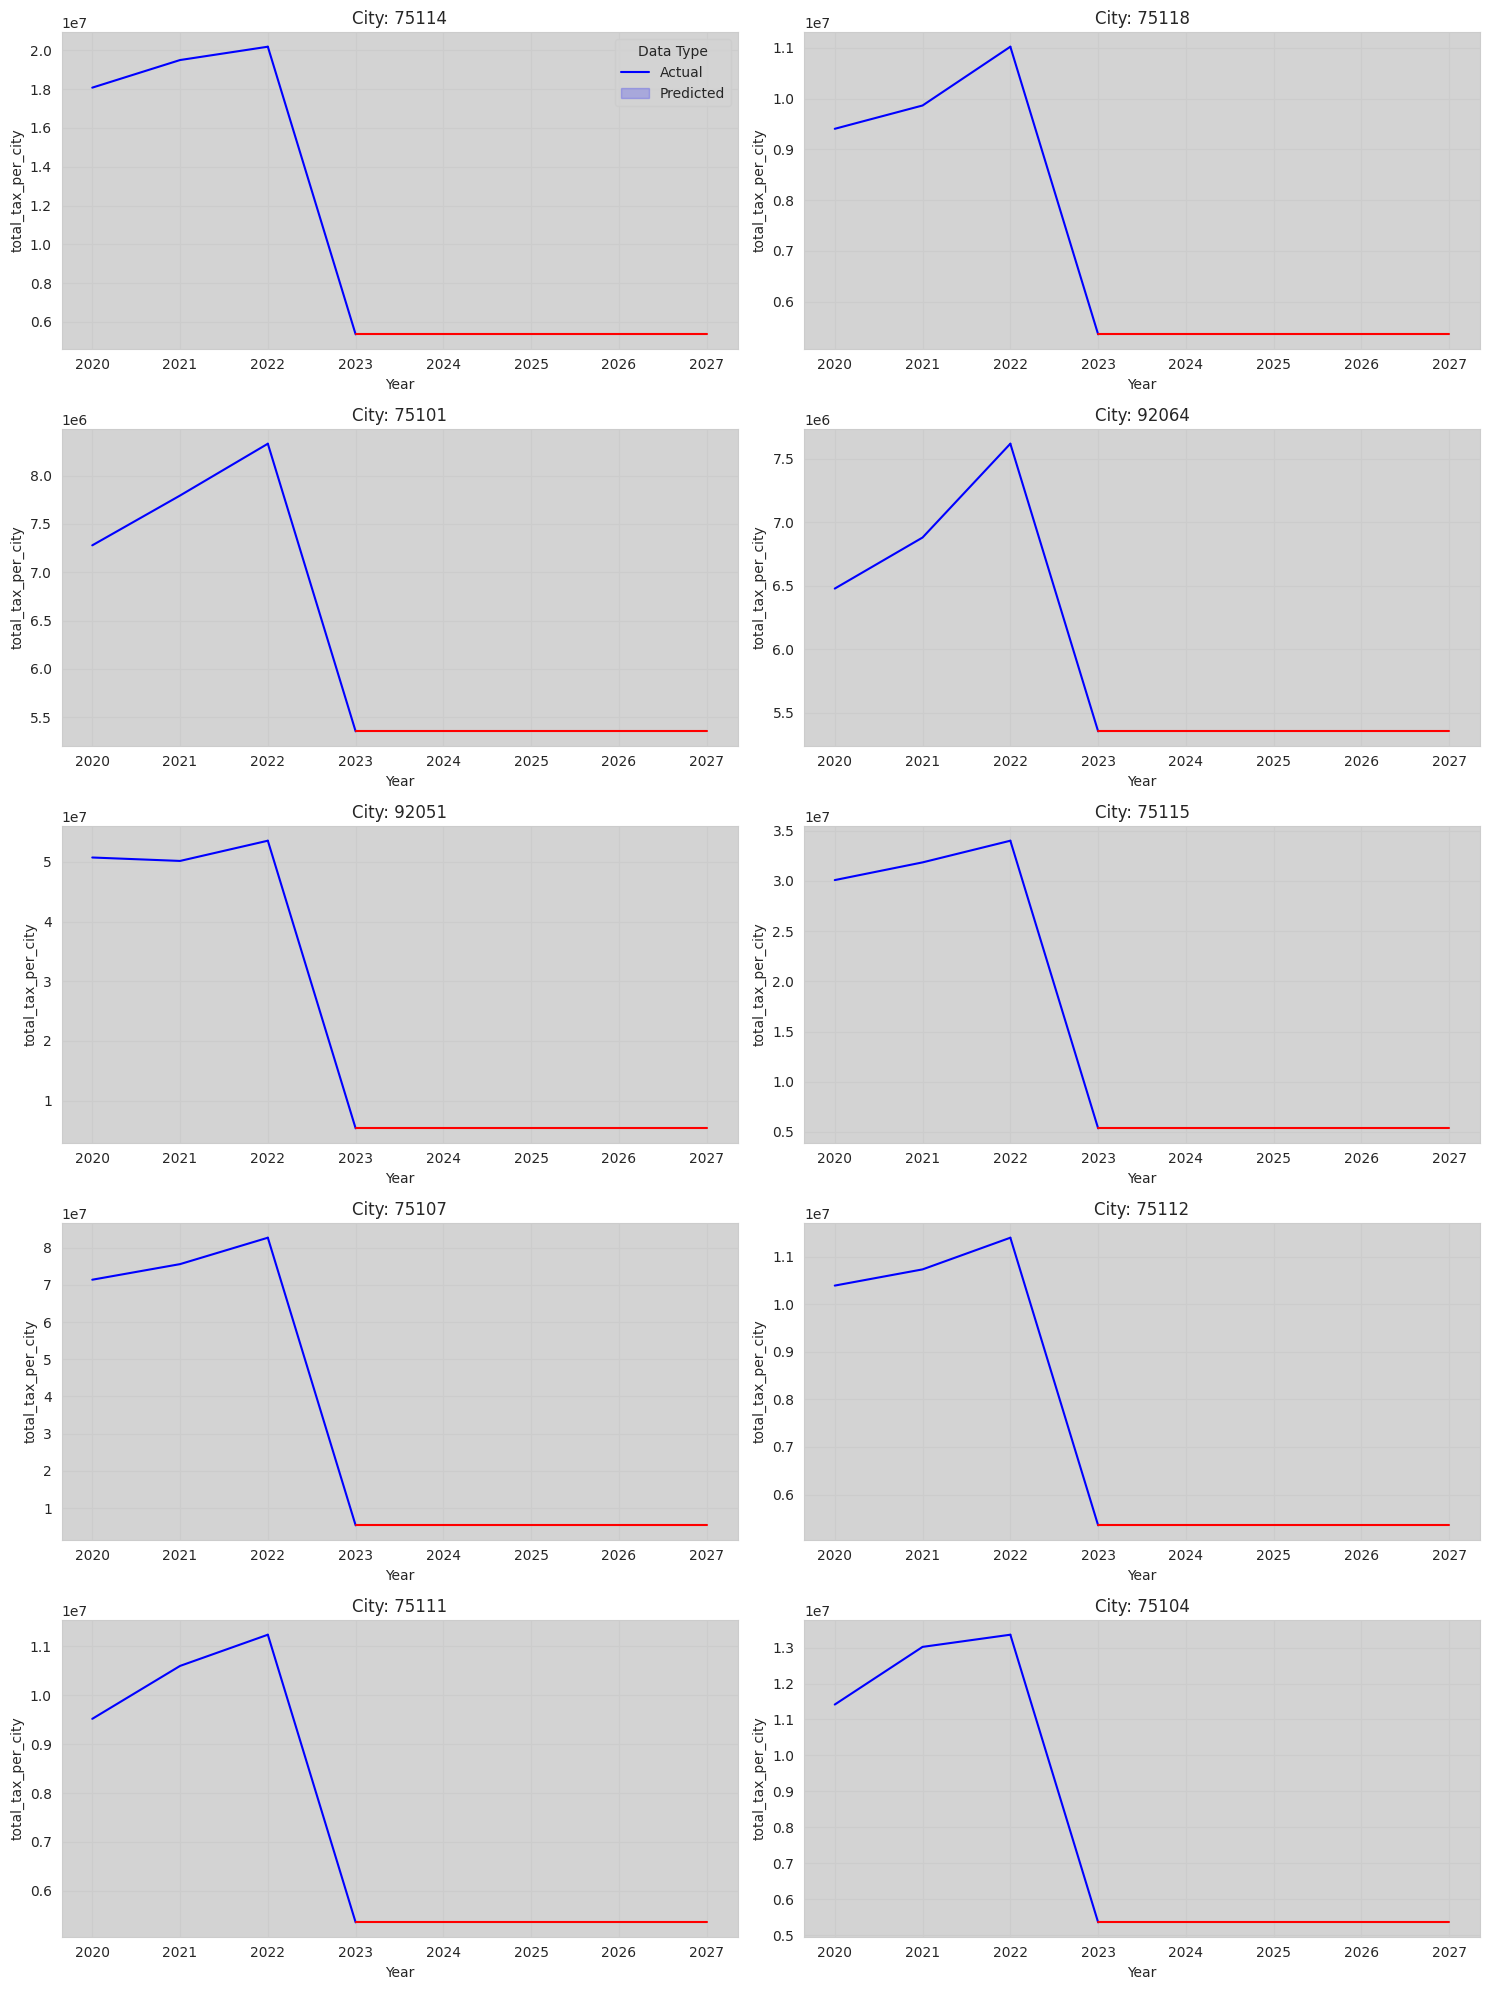

In [22]:
'''
For review:

This graph displays the outlier cities along with their predictions using the XGBoost model.
As initially indicated, these cities were not used to train the model due to their exceptionally high values.
This could potentially impact the model's performance for other cities.
However, it's evident that the model predicts values that are inconsistent with the time series for each city.
Consequently, a different model will be utilized for these predictions.
'''

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set_style("whitegrid", {'axes.facecolor': 'lightgray'})

def extract_outlier_data(df, outlier_communes):
    """Extract data for outlier cities."""
    return df[df['Commune_Code_INSEE'].isin(outlier_communes)]

def compute_growth_rates(df):
    """Calculate growth rates for each outlier city."""
    growth_rates = {}
    for city in df['Commune_Code_INSEE'].drop_duplicates():
        city_data = df[df['Commune_Code_INSEE'] == city]
        growth_rates[city] = (city_data['total_tax_per_city'].iloc[-1] - city_data['total_tax_per_city'].iloc[0]) / city_data['total_tax_per_city'].iloc[0]
    return growth_rates

# Extract data and compute growth rates
outlier_data = extract_outlier_data(df_ificom_clean_to_be_predictedV2, outlier_communes)
growth_rates_df = pd.DataFrame(list(compute_growth_rates(outlier_data).items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# Randomly select 10 cities for visualization
sampled_cities = growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
sampled_data = outlier_data[outlier_data['Commune_Code_INSEE'].isin(sampled_cities)].sort_values(by='Year')

# Plot the data for the chosen cities
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for idx, city in enumerate(sampled_cities):
    row, col = divmod(idx, 2)
    city_data = sampled_data[sampled_data['Commune_Code_INSEE'] == city]

    # Plot actual data
    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    # Connect actual to predicted
    last_actual = city_data[city_data['predicted'] == False].iloc[-1]
    first_predicted = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_actual['Year'], first_predicted['Year']], [last_actual['total_tax_per_city'], first_predicted['total_tax_per_city']], color='b')

    # Plot predicted data
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Data Type', labels=['Actual', 'Predicted'])

plt.tight_layout()
plt.show()


Based on the observations, the model struggles to provide accurate predictions for outlier cities because it wasn't trained using these atypical values.
Training the model with these outliers could have compromised its performance for the majority of cities with more typical values.


In [ ]:
'''#For review, this graph displays the outlier cities along with their predictions using the XGBoost model. As initially indicated, these cities were not used to train the model due to their exceptionally high values, which could potentially impact the model's performance for other cities. However, it's evident that the model predicts values that are inconsistent with the time series for each city. Consequently, a different model will be utilized for these predictions.

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style to whitegrid with background color light gray
sns.set_style("whitegrid", {'axes.facecolor': 'lightgray'})

# 1. Extract data for outlier cities.
outlier_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Compute growth rates for each outlier city.
def compute_growth_rates(dataframe):
    growth_rates = {}
    for city in dataframe['Commune_Code_INSEE'].drop_duplicates():
        city_data = dataframe[dataframe['Commune_Code_INSEE'] == city]
        initial_value = city_data['total_tax_per_city'].iloc[0]
        final_value = city_data['total_tax_per_city'].iloc[-1]
        growth_rates[city] = (final_value - initial_value) / initial_value
    return growth_rates

growth_rates = compute_growth_rates(outlier_data)
growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# 3. Randomly select 10 outlier cities for visualization.
sampled_cities = growth_rates_df.sample(10)['Commune_Code_INSEE'].tolist()
sampled_data = outlier_data[outlier_data['Commune_Code_INSEE'].isin(sampled_cities)].sort_values(by='Year')

# 4. Visualize data for the selected cities.
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for idx, city in enumerate(sampled_cities):
    row, col = divmod(idx, 2)
    city_data = sampled_data[sampled_data['Commune_Code_INSEE'] == city]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)

    last_actual = city_data[city_data['predicted'] == False].iloc[-1]
    first_predicted = city_data[city_data['predicted'] == True].iloc[0]
    axes[row, col].plot([last_actual['Year'], first_predicted['Year']], [last_actual['total_tax_per_city'], first_predicted['total_tax_per_city']], color='b')

    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Data Type', labels=['Actual', 'Predicted'])

plt.tight_layout()
plt.show()


### Predicting for Outlier Cities with Prophet

In this section, we leverage the Facebook Prophet algorithm to forecast for cities identified as outliers. Prophet offers a straightforward implementation and effectively captures the trends and seasonality of time series data, making it an ideal choice for this task.

In [ ]:
'''from prophet import Prophet  # Make sure you have the correct import based on your installation

# Step 1: Filter the dataframe
df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Step 2: Split the data into known and unknown datasets
known_data = df[df['predicted'] == False]
unknown_data = df[df['predicted'] == True]

predicted_values = []

# Step 3: Forecasting for each unique Commune_Code_INSEE
for commune in known_data['Commune_Code_INSEE'].unique():

    # Prepare the dataset for this commune
    commune_data = known_data[known_data['Commune_Code_INSEE'] == commune]
    commune_forecast = unknown_data[unknown_data['Commune_Code_INSEE'] == commune]

    # Prepare data for Prophet
    ts_data = pd.DataFrame({
        'ds': pd.to_datetime(commune_data['Year'], format='%Y'),
        'y': commune_data['total_tax_per_city']
    })

    # External regressors
    '''
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        ts_data[col] = commune_data[col].fillna(commune_data[col].median())  # Imputación de valores NaN
    '''
    for col in ['latitude', 'longitude','mean_distance_to_10_nearest']:
        ts_data[col] = commune_data[col].fillna(commune_data[col].median())  # Filling NaN values

    # Initialize and train the Prophet model
    model = Prophet(yearly_seasonality=True)
    '''
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        model.add_regressor(col)
    '''
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        model.add_regressor(col)

    model.fit(ts_data)

    # Prepare dataframe for prediction
    future = model.make_future_dataframe(periods=len(commune_forecast), freq='Y')

    concatenated_data = pd.concat([commune_data.reset_index(drop=True), commune_forecast.reset_index(drop=True)], ignore_index=True)

    # Now assign the columns to future, ensuring no NaN values
    for col in ['latitude', 'longitude', 'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest']:
        future[col] = concatenated_data[col].fillna(concatenated_data[col].median())

    # Predict
    forecast = model.predict(future)

    # Append the predicted values for the unknown data
    predicted_values.extend(forecast['yhat'][-len(commune_forecast):].tolist())

# Step 4: Add the predicted values to the unknown data using .loc to avoid warnings
unknown_data.loc[unknown_data['Commune_Code_INSEE'].isin(known_data['Commune_Code_INSEE'].unique()), 'total_tax_per_city'] = predicted_values
unknown_data['Prophet'] = True  # This line assumes that the 'Prophet' column should be True for all rows in unknown_data

# The dataframe with the predicted values
# unknown_data


In [24]:
from prophet import Prophet

# Step 1: Filter data to only include outlier cities
df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Step 2: Separate data into known historical values and future values to be predicted
known_data = df[df['predicted'] == False]
unknown_data = df[df['predicted'] == True]

predicted_values = []

# Step 3: Perform forecasting for each city
for commune in known_data['Commune_Code_INSEE'].unique():

    commune_data = known_data[known_data['Commune_Code_INSEE'] == commune]
    commune_forecast = unknown_data[unknown_data['Commune_Code_INSEE'] == commune]

    # Skip if not enough data points
    if len(commune_data) < 2:
        continue

    # Format data for Prophet
    ts_data = pd.DataFrame({
        'ds': pd.to_datetime(commune_data['Year'], format='%Y'),
        'y': commune_data['total_tax_per_city']
    })

    # Add external regressors and handle missing values
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        ts_data[col] = commune_data[col].fillna(commune_data[col].median())

    # Initialize Prophet model, add regressors, and train the model
    model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        model.add_regressor(col)
    model.fit(ts_data)

    # Setup dataframe for forecasting
    future = model.make_future_dataframe(periods=len(commune_forecast), freq='Y')
    concatenated_data = pd.concat([commune_data.reset_index(drop=True), commune_forecast.reset_index(drop=True)], ignore_index=True)
    for col in ['latitude', 'longitude', 'mean_distance_to_10_nearest']:
        future[col] = concatenated_data[col].fillna(concatenated_data[col].median())

    # Make predictions
    forecast = model.predict(future)
    predicted_values.extend(forecast['yhat'][-len(commune_forecast):].tolist())

# Step 4: Assign the predicted values to the unknown data
unknown_data.loc[unknown_data['Commune_Code_INSEE'].isin(known_data['Commune_Code_INSEE'].unique()), 'total_tax_per_city'] = predicted_values
unknown_data['Prophet'] = True  # Mark rows as predicted by Prophet


INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kab4qix/b2g13r_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kab4qix/le2xh3b2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=949', 'data', 'file=/tmp/tmp0kab4qix/b2g13r_l.json', 'init=/tmp/tmp0kab4qix/le2xh3b2.json', 'output', 'file=/tmp/tmp0kab4qix/prophet_modelz2_muoyl/prophet_model-20231101222107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 2.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0kab4qix/ca2ftoad.json
DEBUG:cmdstanpy:input tempfile: 

In [25]:
# Copy predictions from unknown_data to df_ificom_clean_to_be_predictedV2
for index, row in unknown_data.iterrows():
    # Locate the matching row index in df_ificom_clean_to_be_predictedV2
    target_index = df_ificom_clean_to_be_predictedV2[
        (df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'] == row['Commune_Code_INSEE']) &
        (df_ificom_clean_to_be_predictedV2['Year'] == row['Year'])
    ].index[0]

    # Update the columns in df_ificom_clean_to_be_predictedV2 using values from unknown_data
    for column in ['latitude', 'longitude', 'total_tax_per_city', 'total_tax_per_city_lag1',
                   'mean', 'median', 'min', 'max', 'mean_distance_to_10_nearest',
                   'to_be_predicted', 'predicted', 'Prophet']:
        df_ificom_clean_to_be_predictedV2.at[target_index, column] = row[column]

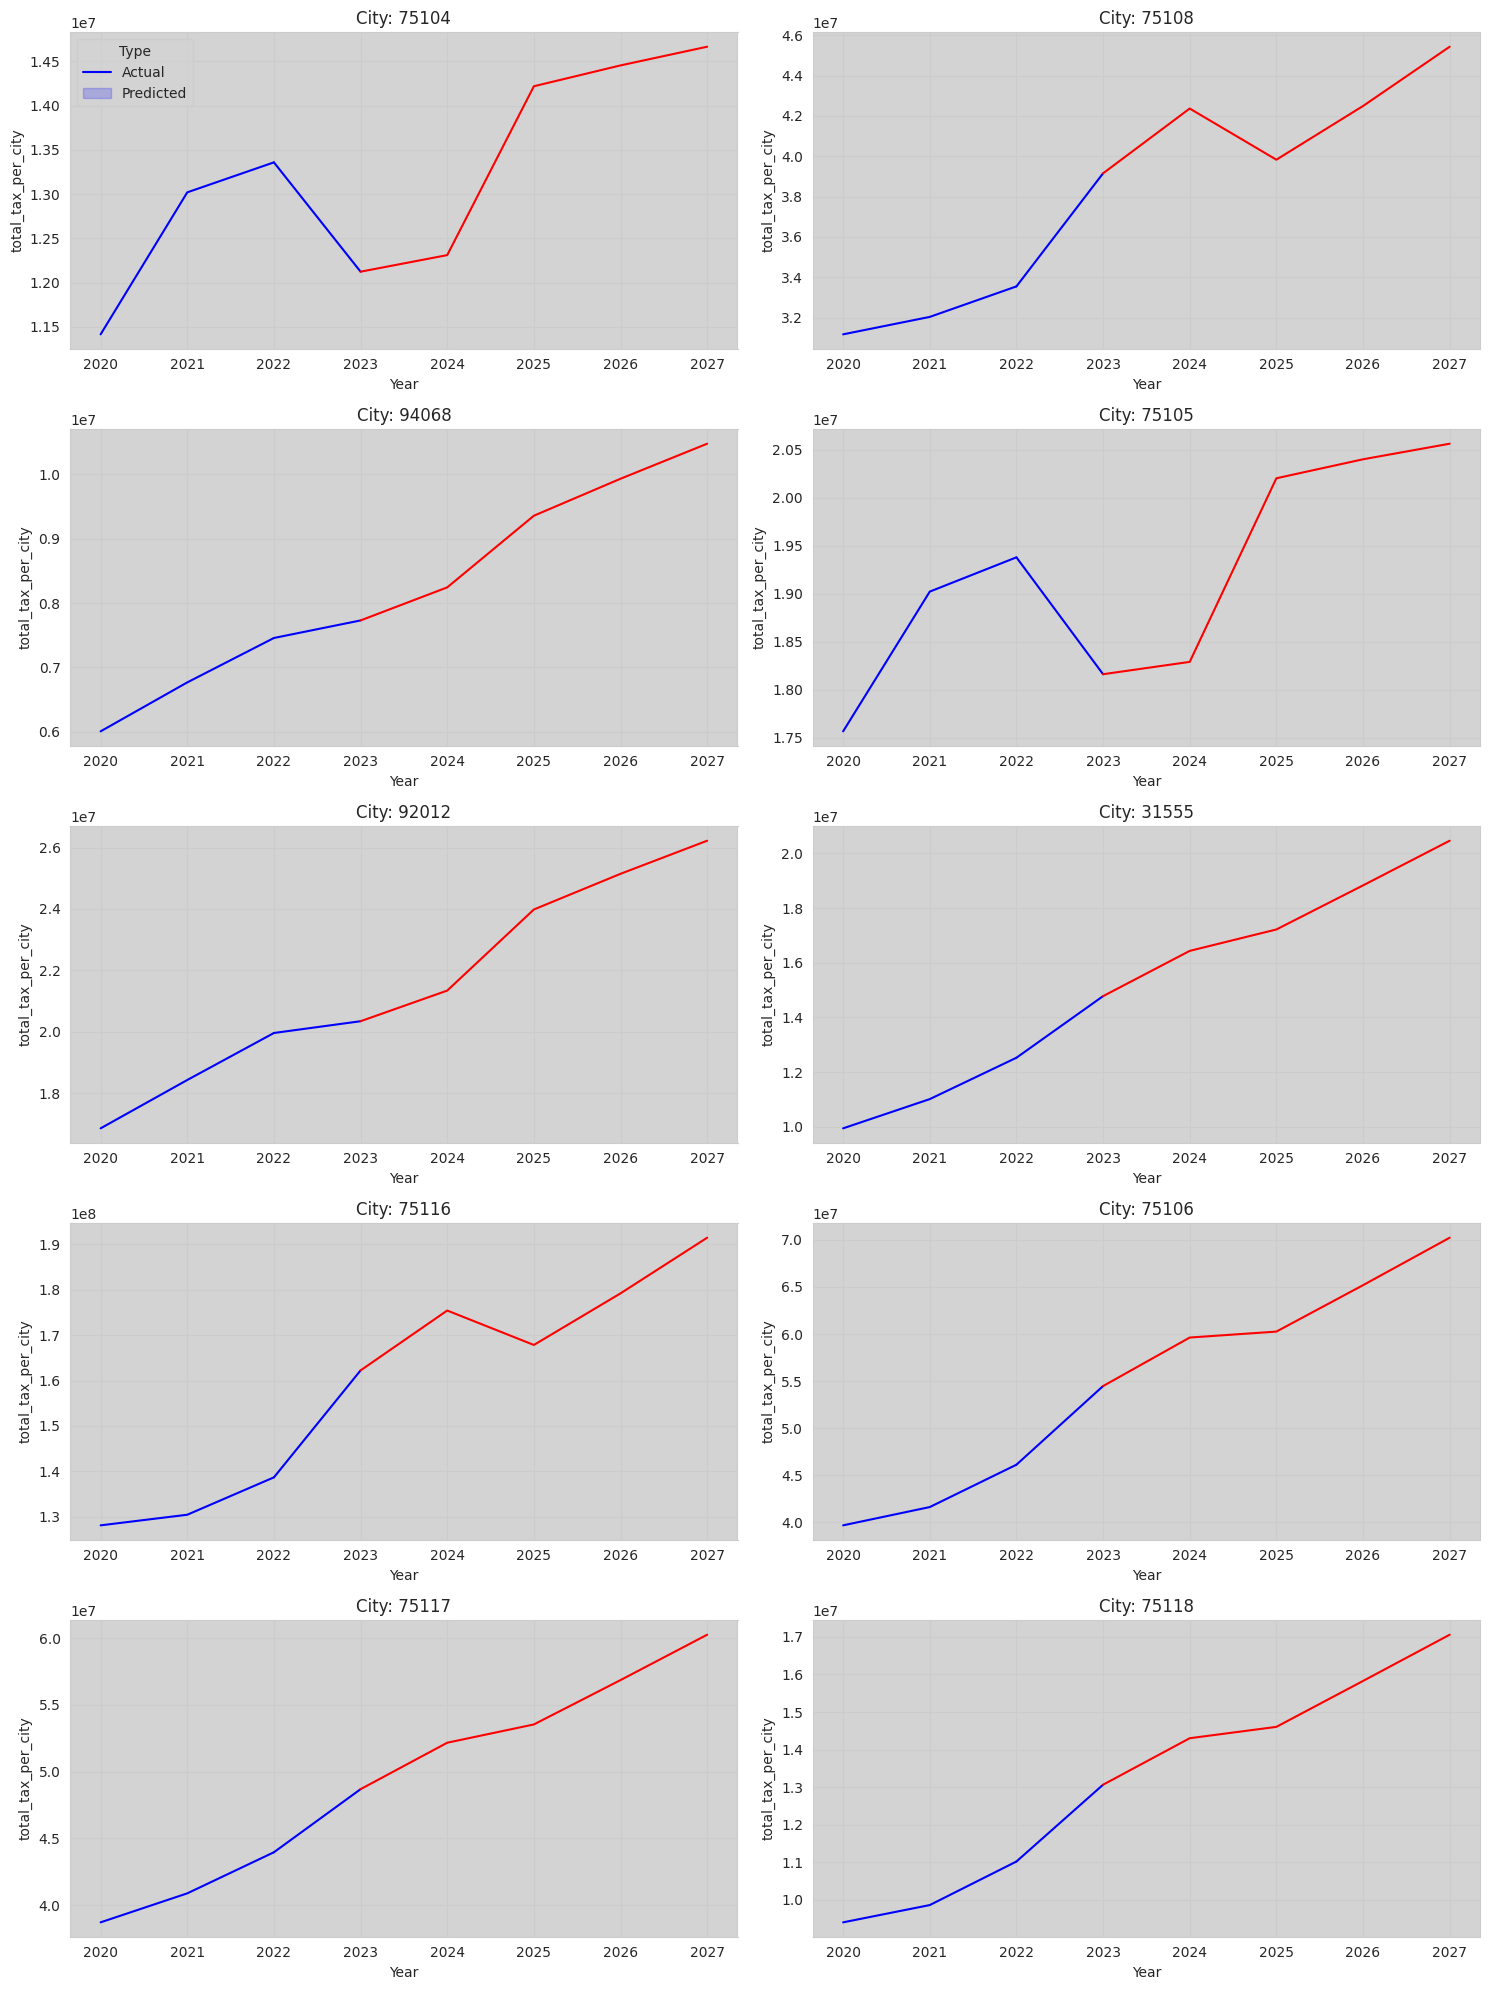

In [27]:
"""
This script visualizes prediction results using the Prophet method for cities that are identified as outliers.
The steps include extracting outlier cities, calculating their growth rates, selecting a random sample of 10 cities,
and plotting the actual vs predicted tax values over the years for these cities.
"""

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract outlier cities
outlier_df = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# 2. Calculate the growth rate for each outlier city
growth_rates = {}
for city in outlier_df['Commune_Code_INSEE'].drop_duplicates():
    city_data = outlier_df[outlier_df['Commune_Code_INSEE'] == city]
    initial_value = city_data['total_tax_per_city'].iloc[0]
    final_value = city_data['total_tax_per_city'].iloc[-1]

    growth_rate = (final_value - initial_value) / initial_value
    growth_rates[city] = growth_rate

# Convert growth rates to DataFrame
growth_rates_df = pd.DataFrame(list(growth_rates.items()), columns=['Commune_Code_INSEE', 'GrowthRate'])

# 3. Select 10 random outlier cities
random_10_cities = growth_rates_df['Commune_Code_INSEE'].sample(10).tolist()
selected_data = outlier_df[outlier_df['Commune_Code_INSEE'].isin(random_10_cities)].sort_values(by='Year')

# 4. Plot data for these cities
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
for idx, city in enumerate(random_10_cities):
    row = idx // 2
    col = idx % 2
    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city]

    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b')
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    axes[row, col].set_title(f'City: {city}')

axes[0, 0].legend(title='Type', labels=['Actual', 'Predicted'])

plt.tight_layout()
plt.show()


# Analyzing Prediction Outcomes

In this notebook, we delve into the results of our predictive modeling. We aim to visualize, study, and understand the outcomes, gauging the accuracy and pinpointing potential areas for model enhancement. This analysis will serve as a foundation for refining our approach and making more informed decisions in future iterations.

In [28]:
# 0. Filter out outlier cities
df_filtered = df_ificom_clean_to_be_predictedV2[~df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(outlier_communes)]

# Identify cities that lack data specifically for the years 2020, 2021, and 2022
years_to_check = [2020, 2021, 2022]
cities_to_exclude = [city for city in df_filtered['Commune_Code_INSEE'].unique()
                     if not all(year in df_filtered[df_filtered['Commune_Code_INSEE'] == city]['Year'].values for year in years_to_check)]

# Remove all rows corresponding to the identified cities
df_filtered = df_filtered[~df_filtered['Commune_Code_INSEE'].isin(cities_to_exclude)]

# Filter only for the years between 2022 and 2027 for growth rate calculation
df_filtered_2022_2027 = df_filtered[(df_filtered['Year'] >= 2022) & (df_filtered['Year'] <= 2027)]

# 1. Sort by city and year, then calculate the annual growth rate
df_sorted = df_filtered_2022_2027.sort_values(by=['Commune_Code_INSEE', 'Year'])
df_sorted['Yearly_Growth'] = df_sorted.groupby('Commune_Code_INSEE')['total_tax_per_city'].pct_change() * 100

# 2. Calculate the average annual growth rate for each city
average_growth_rates = df_sorted.groupby('Commune_Code_INSEE')['Yearly_Growth'].mean().reset_index()

# 3. Sort cities by their average annual growth rate
average_growth_rates = average_growth_rates.sort_values(by='Yearly_Growth', ascending=False)

# 4. Select the top 5 and bottom 5 cities based on average annual growth rate
top_5_cities = average_growth_rates.head(5)
bottom_5_cities = average_growth_rates.tail(5)

# Filter the DataFrame for the year 2022
df_2022 = df_ificom_clean_to_be_predictedV2.query('Year == 2022')

# Select columns of interest
columns_of_interest = ['Region', 'Department', 'Commune_Code_INSEE', 'City']
df_abstraction = df_2022[columns_of_interest]

# Remove duplicates (in case there's more than one entry for a given Commune_Code_INSEE in 2022)
df_abstraction = df_abstraction.drop_duplicates()

average_growth_rates=df_abstraction.merge(average_growth_rates, how='left',left_on='Commune_Code_INSEE',right_on='Commune_Code_INSEE').dropna()

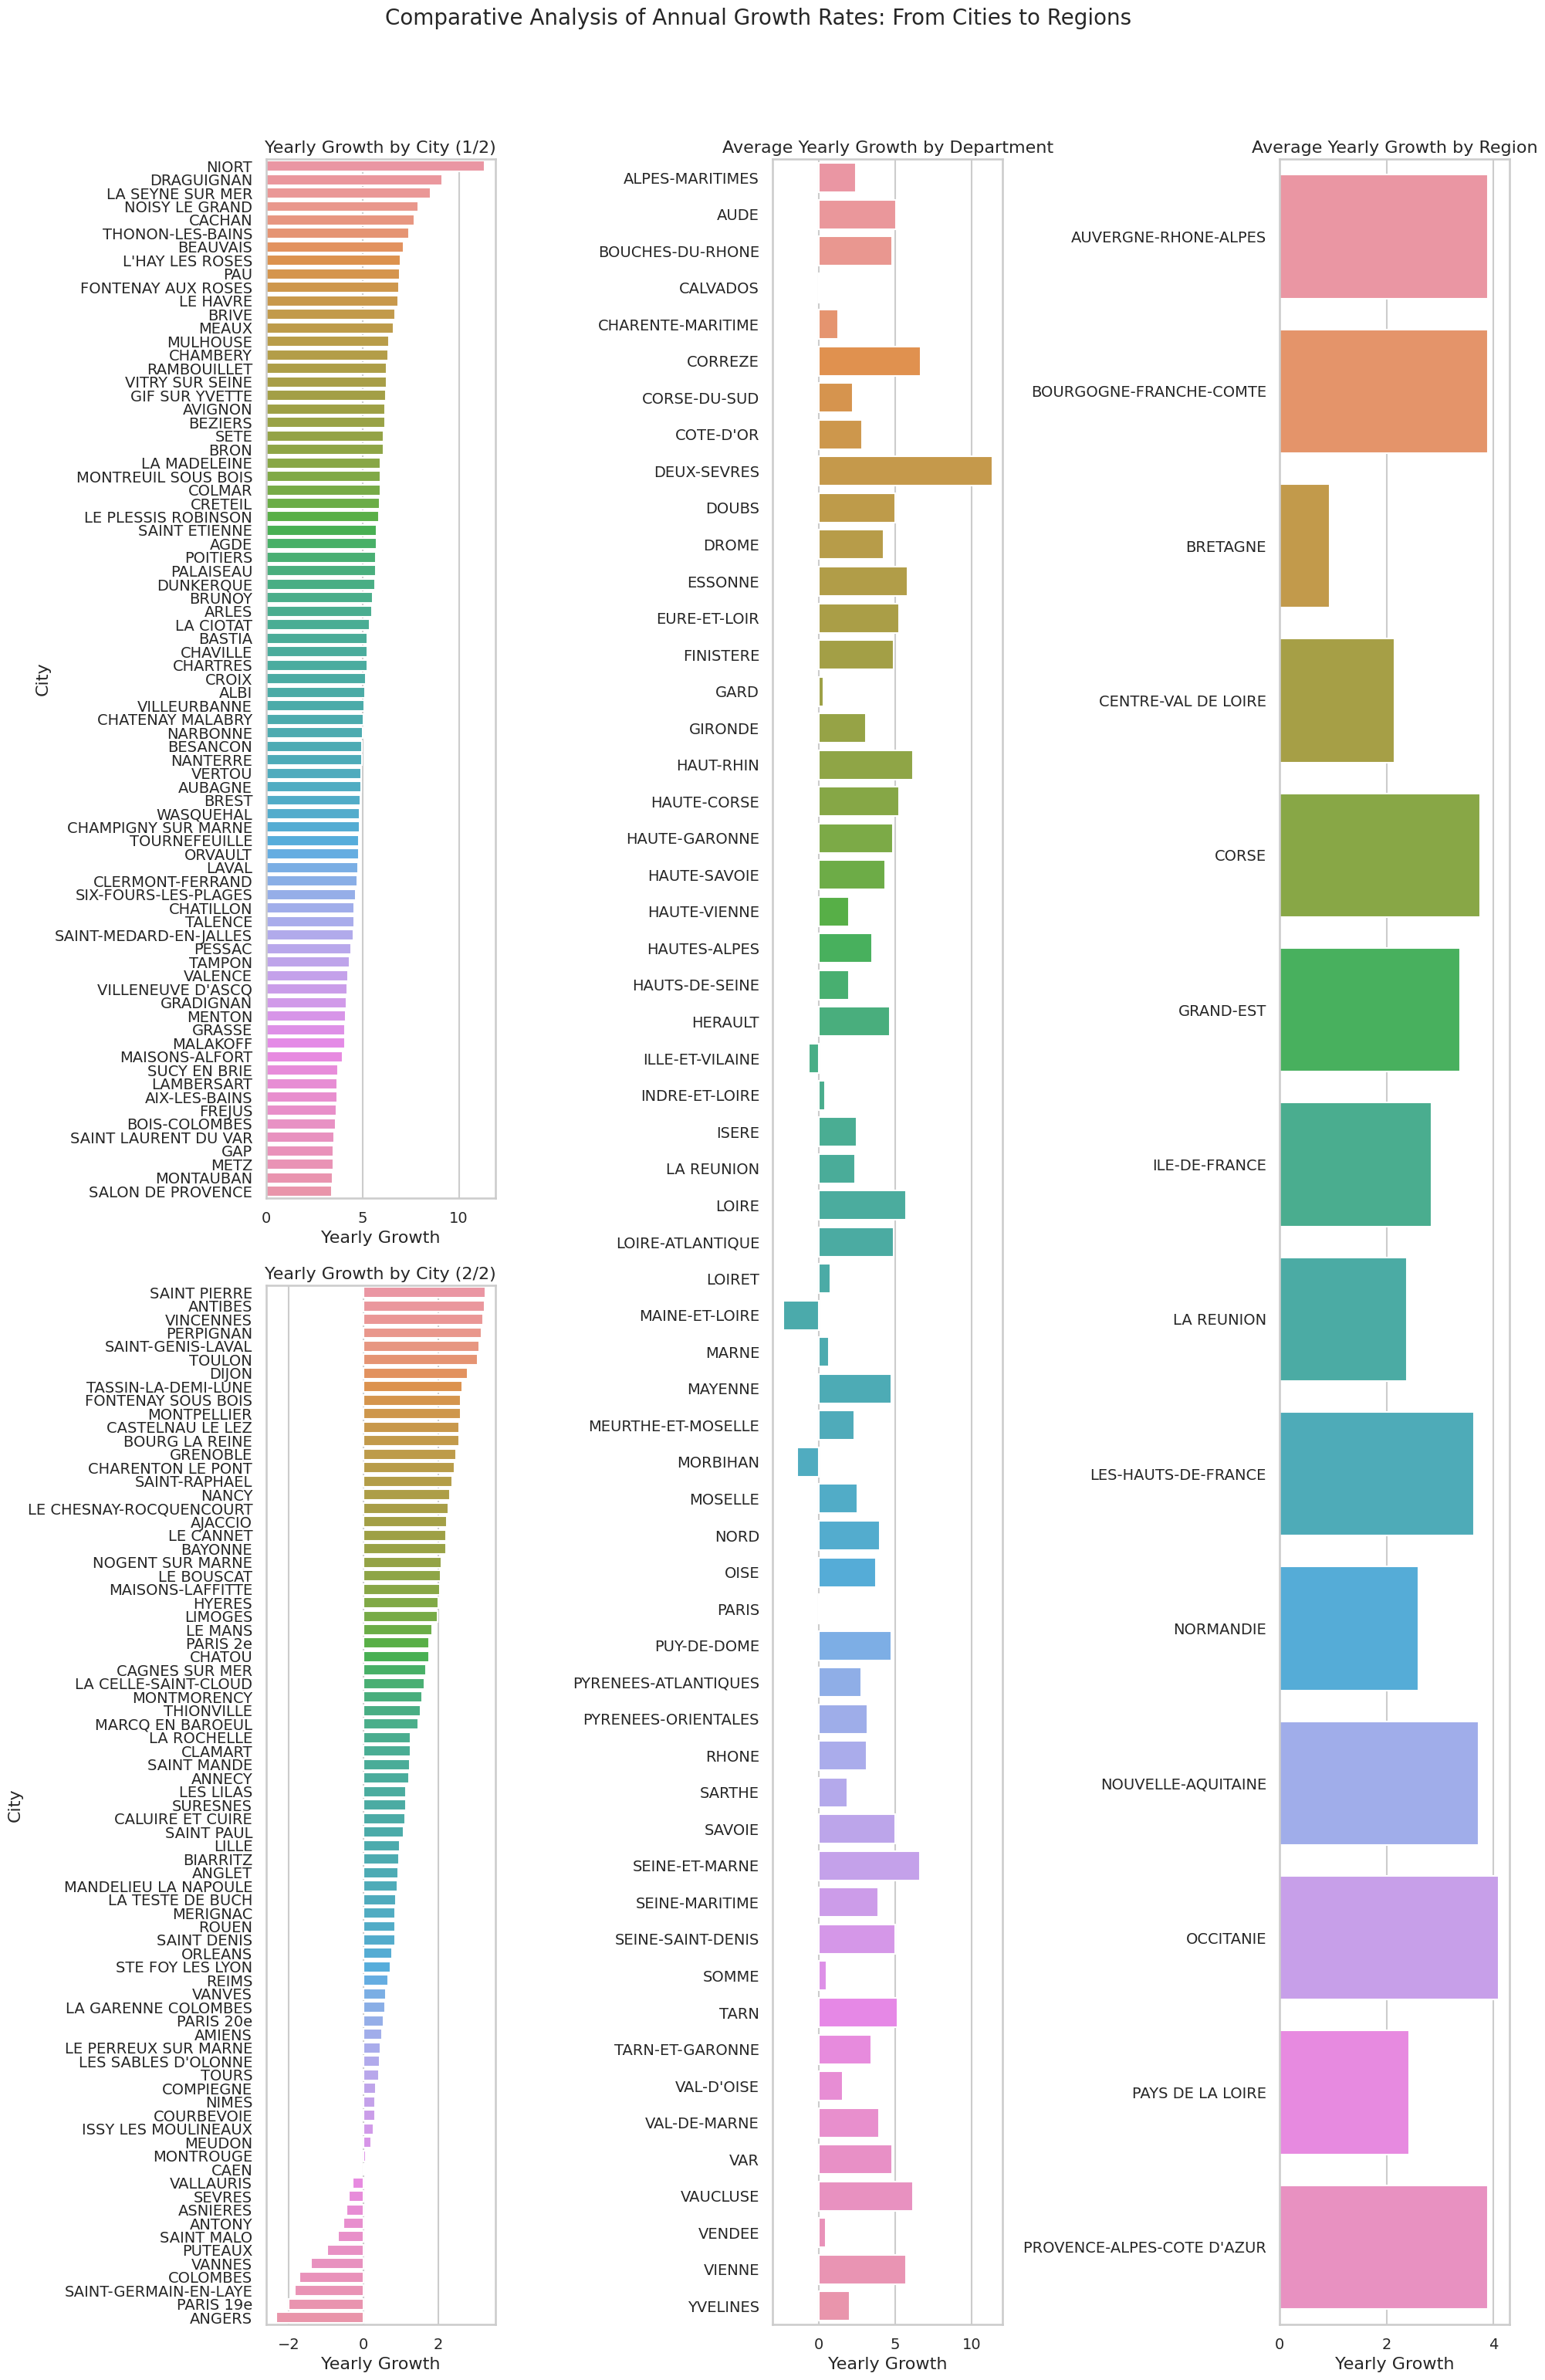

In [32]:
"""
This visualization showcases the annual growth rates of various cities, departments, and regions.
It provides a detailed horizontal bar chart representation, split into two parts for cities due to the large number of data points.
Additionally, it averages the growth rates at the department and region levels to provide insights into broader trends.
"""

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up Seaborn configurations for better visibility
sns.set_theme(style="whitegrid", context="talk", palette="viridis")

# Sort cities by Yearly Growth
sorted_cities = average_growth_rates.sort_values('Yearly_Growth', ascending=False)

# Split the dataset of cities into two
middle_idx = len(sorted_cities) // 2
first_half_cities = sorted_cities.iloc[:middle_idx]
second_half_cities = sorted_cities.iloc[middle_idx:]

# Create a main figure
plt.figure(figsize=(20, 30))

# Title for the entire figure
plt.suptitle("Comparative Analysis of Annual Growth Rates: From Cities to Regions", fontsize=20, y=1.03)

# Horizontal bar chart to display "Yearly Growth" by city (first half)
plt.subplot(2, 3, 1)
sns.barplot(y='City', x='Yearly_Growth', data=first_half_cities)
plt.title('Yearly Growth by City (1/2)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('City', fontsize=16)
plt.xlabel('Yearly Growth', fontsize=16)

# Horizontal bar chart to display "Yearly Growth" by city (second half)
plt.subplot(2, 3, 4)
sns.barplot(y='City', x='Yearly_Growth', data=second_half_cities)
plt.title('Yearly Growth by City (2/2)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('City', fontsize=16)
plt.xlabel('Yearly Growth', fontsize=16)

# Calculate averages by Department and Region
average_growth_by_department = average_growth_rates.groupby('Department').mean(numeric_only=True).reset_index()
average_growth_by_region = average_growth_rates.groupby('Region').mean(numeric_only=True).reset_index()

# Horizontal bar chart to display average "Yearly Growth" by department
plt.subplot(1, 3, 2)
sns.barplot(y='Department', x='Yearly_Growth', data=average_growth_by_department, estimator=np.mean, errorbar=None)
plt.title('Average Yearly Growth by Department', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Yearly Growth', fontsize=16)

# Horizontal bar chart to display average "Yearly Growth" by region
plt.subplot(1, 3, 3)
sns.barplot(y='Region', x='Yearly_Growth', data=average_growth_by_region, estimator=np.mean, errorbar=None)
plt.title('Average Yearly Growth by Region', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('')
plt.xlabel('Yearly Growth', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
"""
Analysis:

- Cities:
  - Growth varies widely, from -2 to 10.
  - 'SALON DE PROVENCE' and 'ANGERS' are high-growth outliers, indicative of strong economic or developmental vigor.
  - In contrast, cities such as 'SAINT-GERMAIN-EN-LAYE' display negative growth, hinting at potential challenges or stagnation.

- Departments:
  - Growth ranges between -1 to 5.
  - 'HAUTES-ALPES' and 'GIRONDE' register significant growth, potentially earmarking them as investment hubs.
  - 'VENDÉE' is on the downturn, a point of concern for regional stakeholders.

- Regions:
  - All regions witness positive growth, peaking at 4.
  - 'PROVENCE-ALPES-CÔTE D'AZUR' and 'PAYS DE LA LOIRE' lead the pack, signaling regional prosperity or efficient initiatives.

Insights:
- Majority areas trend towards positive growth, but there's pronounced disparity among cities within identical departments or regions.
- High-growth zones might be riding on the back of propitious policies, tourism influx, or industrial upsurges.
- Uniformly positive growth at the regional level denotes widespread success; however, city-level disparities unmask localized challenges or boons.
- Negative growth precincts might necessitate targeted interventions or a deeper dive to unearth root causes.
"""


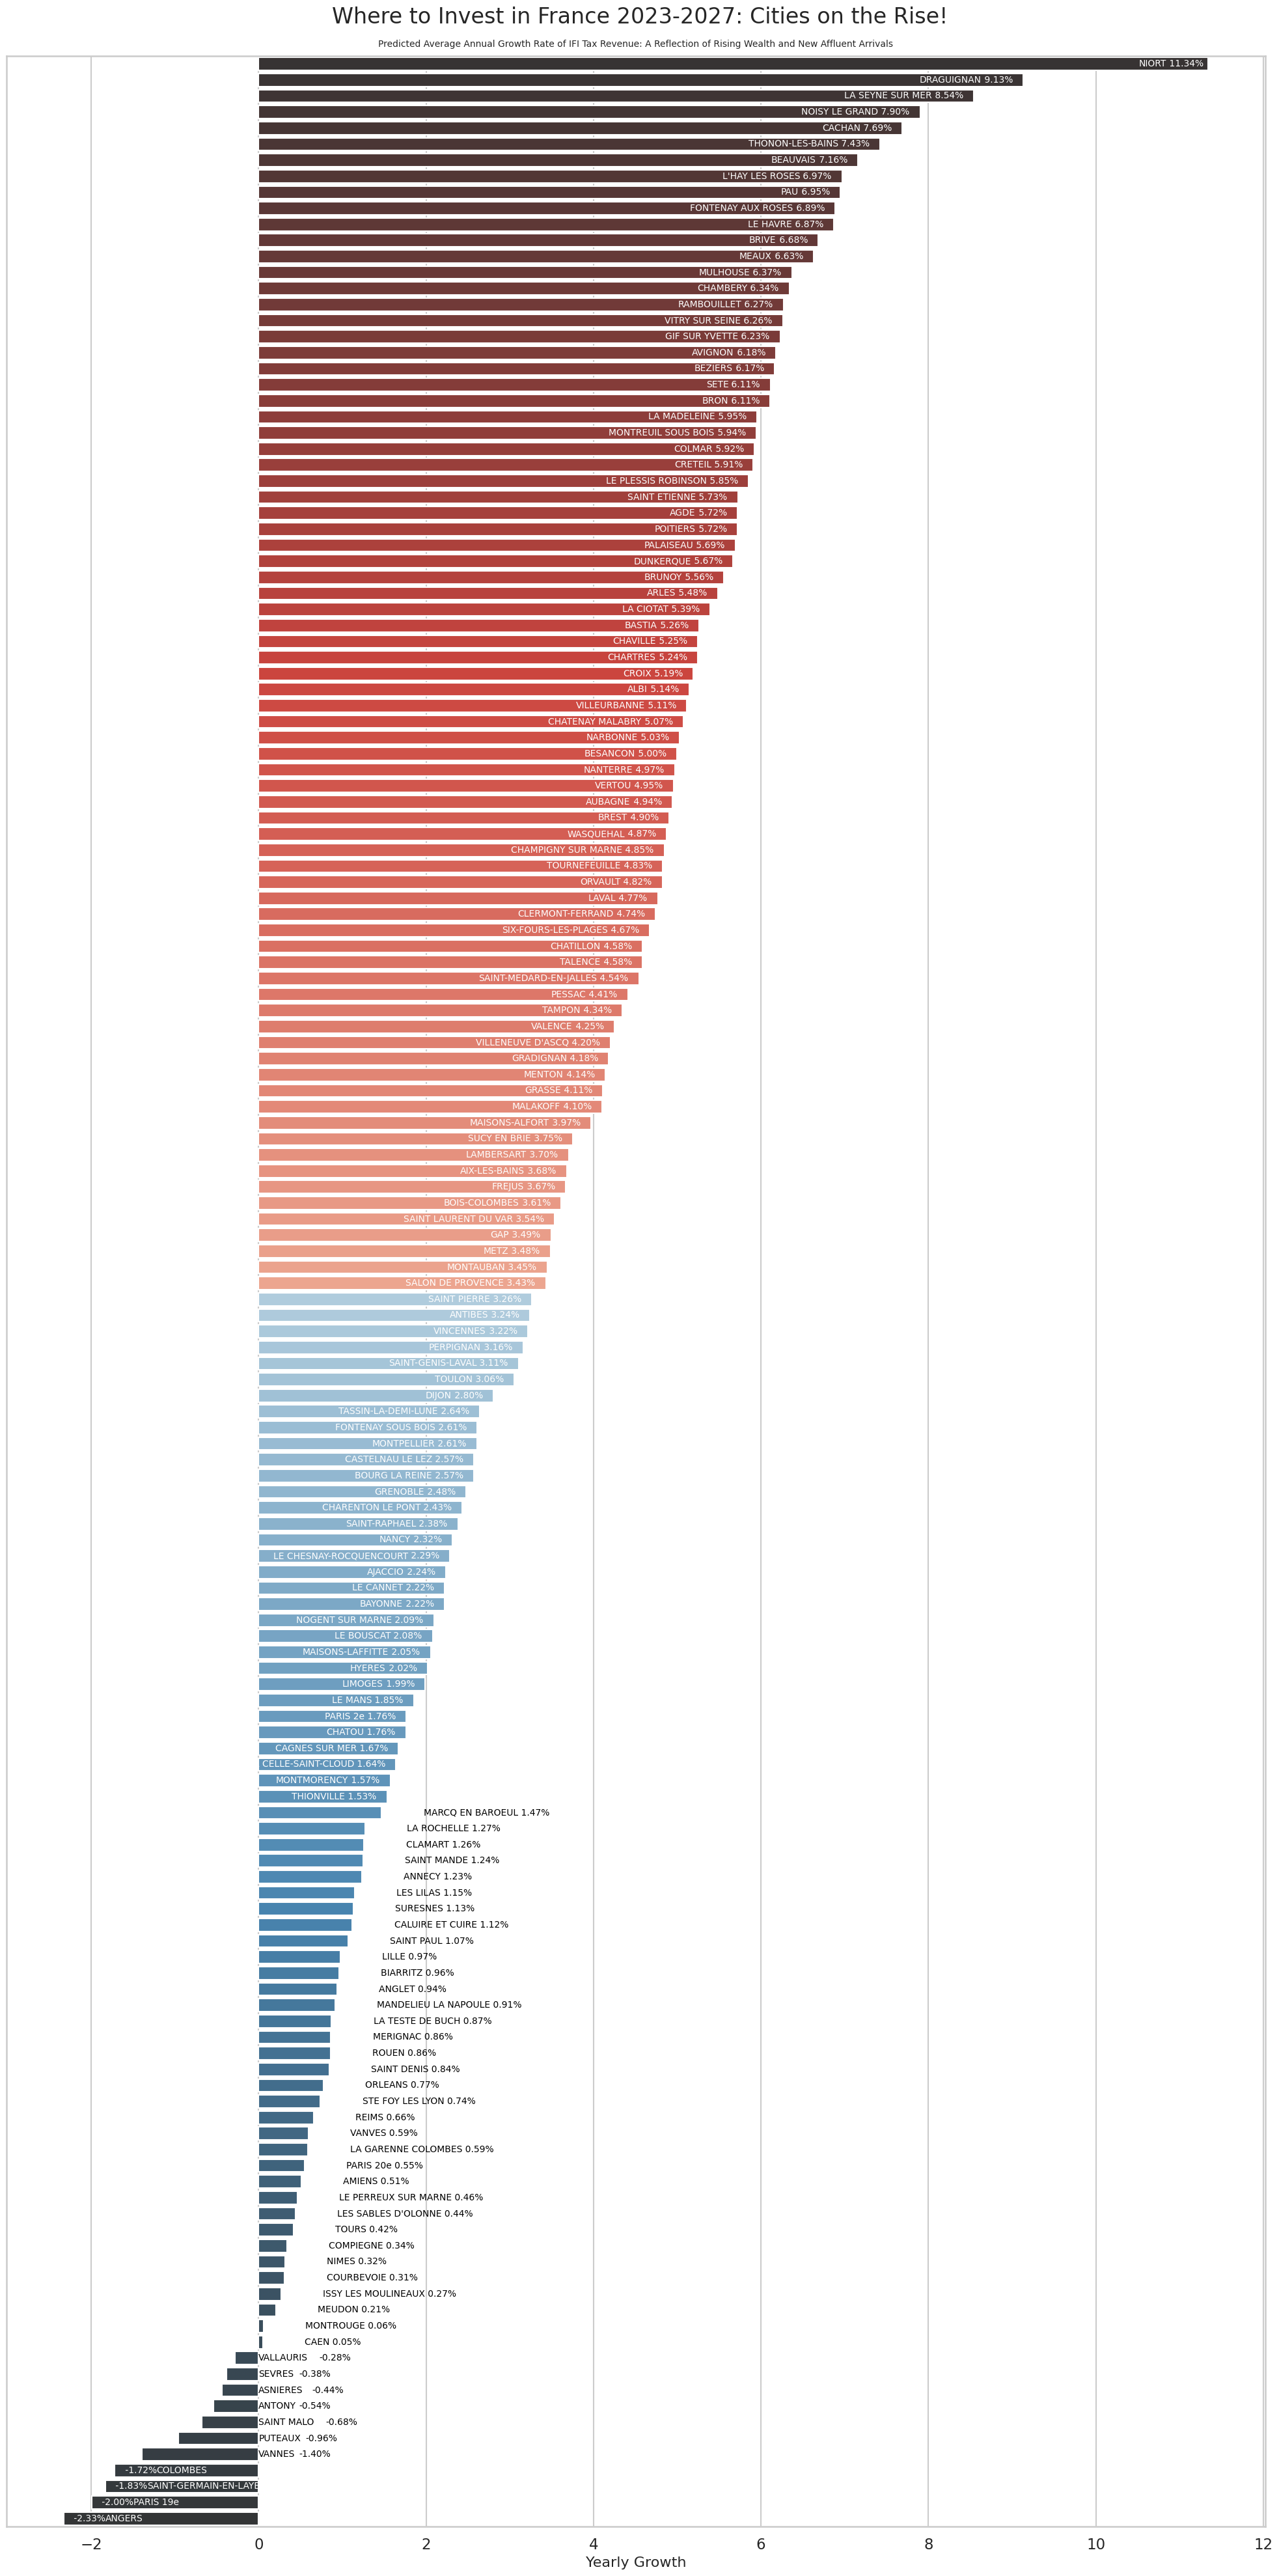

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ajustes a la configuración de Seaborn para mejorar la visibilidad
sns.set_theme(style="whitegrid", context="talk")

# Ordenar ciudades por Yearly Growth
sorted_cities = average_growth_rates.sort_values('Yearly_Growth', ascending=False)

# Crear una figura principal
fig, ax1 = plt.subplots(figsize=(20, 40))

# Construir paleta de colores modernos y oscuros
blue_palette = sns.color_palette("Blues_d", len(sorted_cities) // 2)
red_palette = sns.color_palette("Reds_d", len(sorted_cities) // 2)[::-1]
colors = red_palette + blue_palette

# Gráfico de barras horizontal para mostrar el "Yearly Growth" por ciudad sin etiquetas en el eje Y
sns.barplot(y='City', x='Yearly_Growth', data=sorted_cities, ax=ax1, palette=colors)
ax1.set_yticklabels([])  # Eliminar etiquetas del eje Y

# Anotar el nombre de la ciudad y el crecimiento
for i in range(len(sorted_cities)):
    value, name = sorted_cities['Yearly_Growth'].iloc[i], sorted_cities['City'].iloc[i]

    if value > 1.53 or value < -1.4:
        if value >= 0:
            ax1.text(value - 0.5, i, name, va='center', fontsize=10, color='white', ha='right')
            ax1.text(value - 0.5, i, f' {value:,.2f}%', va='center', fontsize=10, color='white', ha='left')
        else:
            ax1.text(value + 0.5, i, name, va='center', fontsize=10, color='white', ha='left')
            ax1.text(value + 0.5, i, f' {value:,.2f}%', va='center', fontsize=10, color='white', ha='right')
    elif -1.4 < value < -0.28:  # Condición para ciudades entre -0,28% y -1,4%
        ax1.text(0, i, f'{name}', va='center', fontsize=10, color='black', ha='left')
        ax1.text(0 + len(name)*0.08, i, f'{value:,.2f}%', va='center', fontsize=10, color='black', ha='left')
    else:
        if value >= 0:
            ax1.text(value + 0.5, i, f'{name} {value:,.2f}%', va='center', fontsize=10, color='black', ha='left')
        else:
            ax1.text(value - 0.5, i, f'{name} {value:,.2f}%', va='center', fontsize=10, color='black', ha='right')




fig.suptitle('Where to Invest in France 2023-2027: Cities on the Rise!', fontsize=24, y=.991)
ax1.set_title('Predicted Average Annual Growth Rate of IFI Tax Revenue: A Reflection of Rising Wealth and New Affluent Arrivals',
              fontsize=10, pad=10)


ax1.set_ylabel('')  # Eliminar etiqueta del eje Y
ax1.set_xlabel('Yearly Growth', fontsize=16)

plt.tight_layout()
plt.show()


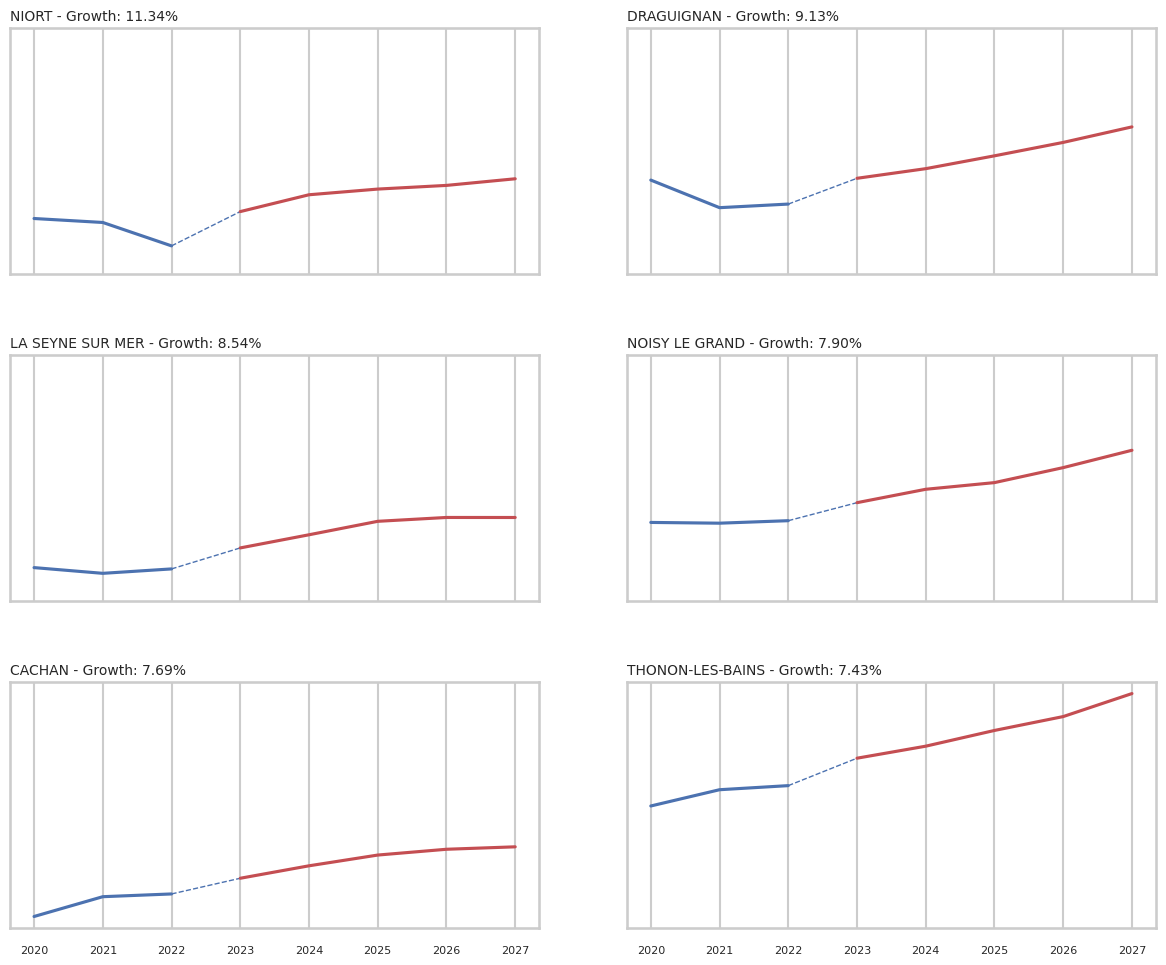

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Estilo de Seaborn
sns.set_style("whitegrid")

# 1. Selecciona las 6 ciudades con el mayor crecimiento anual
top_6_cities = average_growth_rates.sort_values(by="Yearly_Growth", ascending=False).head(6)['Commune_Code_INSEE'].tolist()

# 2. Extraer datos de esas ciudades
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(top_6_cities)]

# 3. Graficar datos para estas ciudades
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

for idx, city_code in enumerate(top_6_cities):
    row = idx // 2
    col = idx % 2

    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city_code]
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    city_name = city_data['City'].iloc[0]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b', linestyle='--', linewidth=1)
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    growth_rate = average_growth_rates[average_growth_rates['Commune_Code_INSEE'] == city_code]['Yearly_Growth'].values[0]
    axes[row, col].set_title(f'{city_name} - Growth: {growth_rate:.2f}%', loc='left', fontsize=10)

    # Eliminar etiquetas y ticks del eje Y
    axes[row, col].set_ylabel('')
    axes[row, col].set_xlabel('')  # Eliminando la etiqueta "Year"
    axes[row, col].yaxis.set_ticks([])
    # Ajustar el formato del eje Y para evitar notación científica
    axes[row, col].get_yaxis().get_major_formatter().set_useOffset(False)

    # Configurar tamaño de fuente para los ejes
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)

# Evitando la creación de una leyenda centralizada
# handles, labels = axes[0,0].get_legend_handles_labels()
# fig.legend(handles, ['Real', 'Predicted'], title='Type', title_fontsize='10', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='8')

plt.tight_layout(h_pad=2.5, w_pad=3.5)
plt.show()


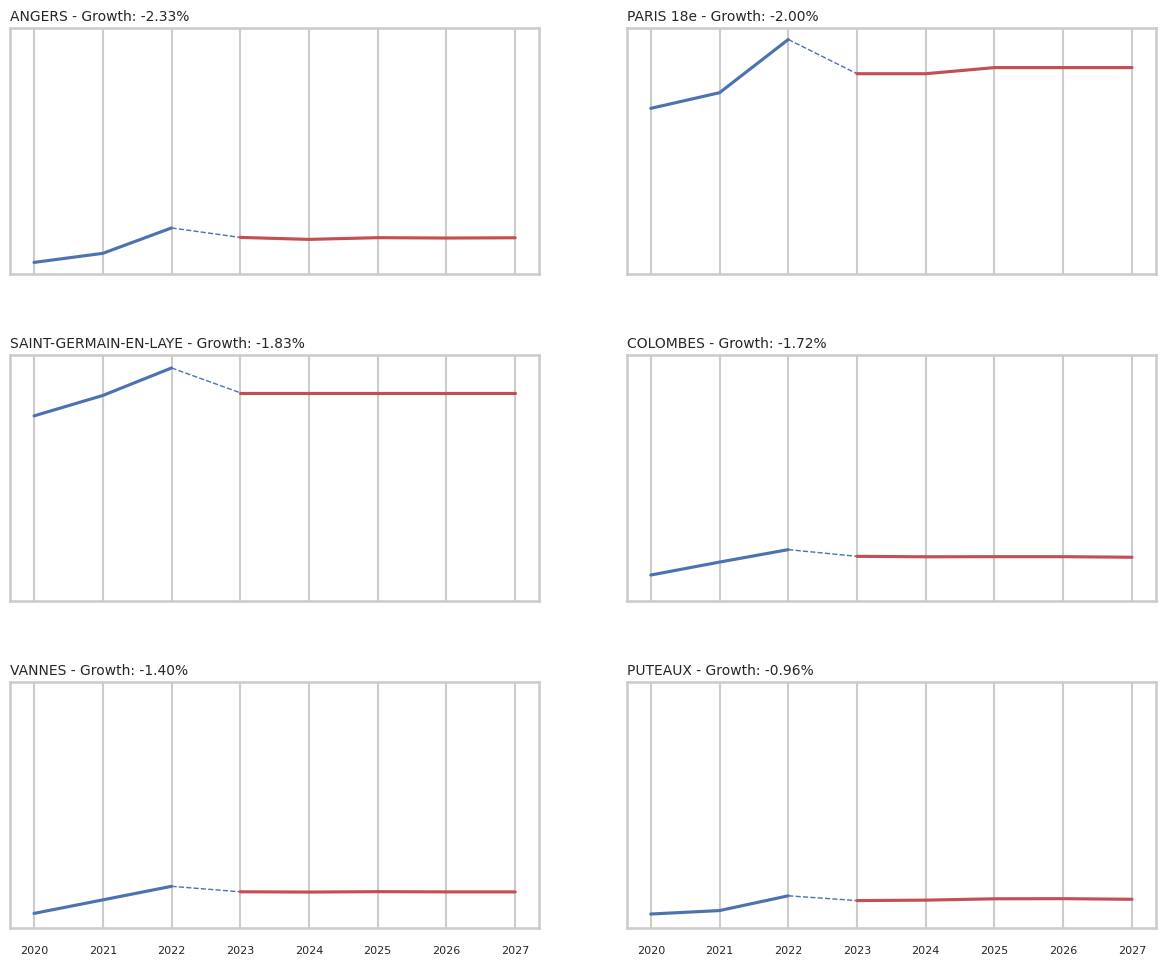

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Estilo de Seaborn
sns.set_style("whitegrid")

# 1. Selecciona las 6 ciudades con el menor crecimiento anual
bottom_6_cities = average_growth_rates.sort_values(by="Yearly_Growth", ascending=True).head(6)['Commune_Code_INSEE'].tolist()

# 2. Extraer datos de esas ciudades
selected_data = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(bottom_6_cities)]

# 3. Graficar datos para estas ciudades
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=True, sharey=True)

for idx, city_code in enumerate(bottom_6_cities):
    row = idx // 2
    col = idx % 2

    city_data = selected_data[selected_data['Commune_Code_INSEE'] == city_code]
    last_false = city_data[city_data['predicted'] == False].iloc[-1]
    first_true = city_data[city_data['predicted'] == True].iloc[0]
    city_name = city_data['City'].iloc[0]

    sns.lineplot(data=city_data[city_data['predicted'] == False], x='Year', y='total_tax_per_city', color='b', ax=axes[row, col], markers=True, dashes=False, legend=False)
    axes[row, col].plot([last_false['Year'], first_true['Year']], [last_false['total_tax_per_city'], first_true['total_tax_per_city']], color='b', linestyle='--', linewidth=1)
    sns.lineplot(data=city_data[city_data['predicted'] == True], x='Year', y='total_tax_per_city', color='r', ax=axes[row, col], markers=True, dashes=False, legend=False)

    growth_rate = average_growth_rates[average_growth_rates['Commune_Code_INSEE'] == city_code]['Yearly_Growth'].values[0]
    axes[row, col].set_title(f'{city_name} - Growth: {growth_rate:.2f}%', loc='left', fontsize=10)

    # Eliminar etiquetas y ticks del eje Y
    axes[row, col].set_ylabel('')
    axes[row, col].set_xlabel('')  # Eliminando la etiqueta "Year"
    axes[row, col].yaxis.set_ticks([])
    # Ajustar el formato del eje Y para evitar notación científica
    axes[row, col].get_yaxis().get_major_formatter().set_useOffset(False)

    # Configurar tamaño de fuente para los ejes
    axes[row, col].tick_params(axis='both', which='major', labelsize=8)

# Evitando la creación de una leyenda centralizada
# handles, labels = axes[0,0].get_legend_handles_labels()
# fig.legend(handles, ['Real', 'Predicted'], title='Type', title_fontsize='10', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize='8')

plt.tight_layout(h_pad=2.5, w_pad=3.5)
plt.show()


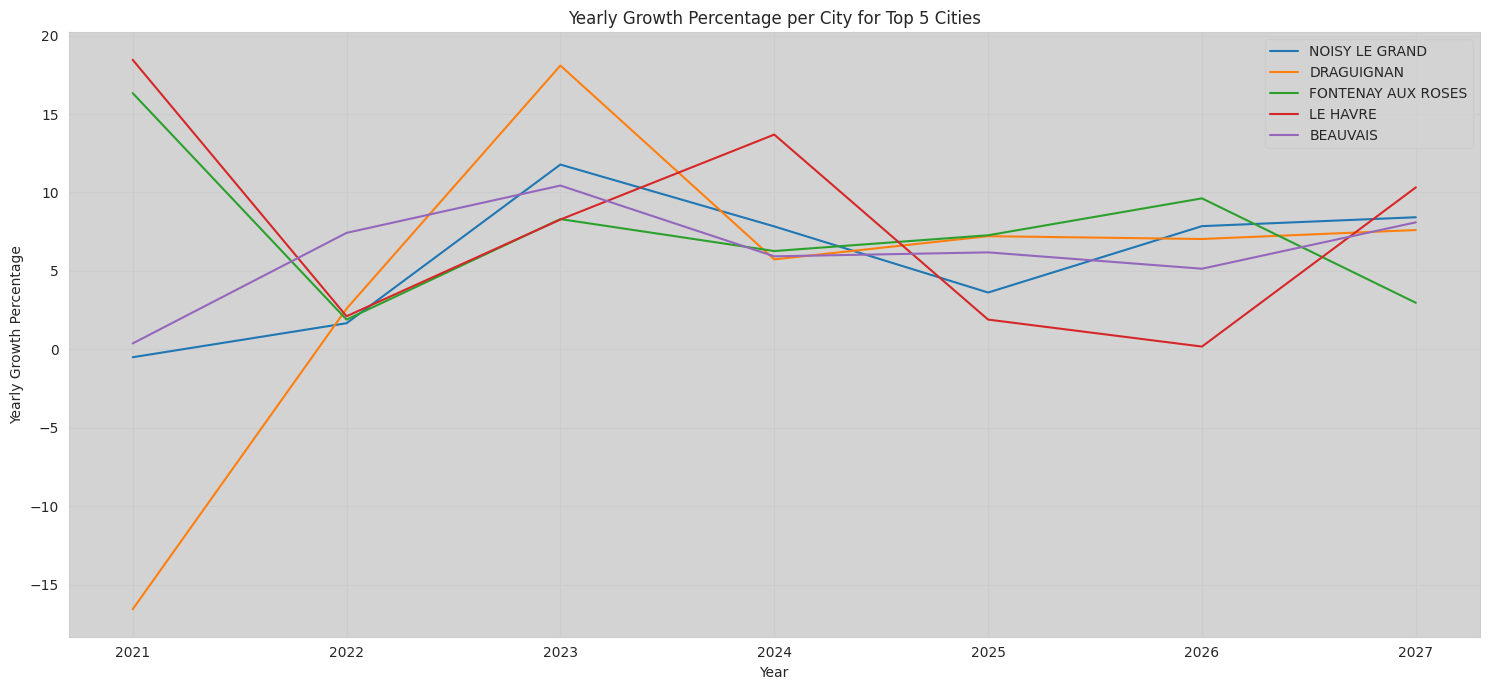

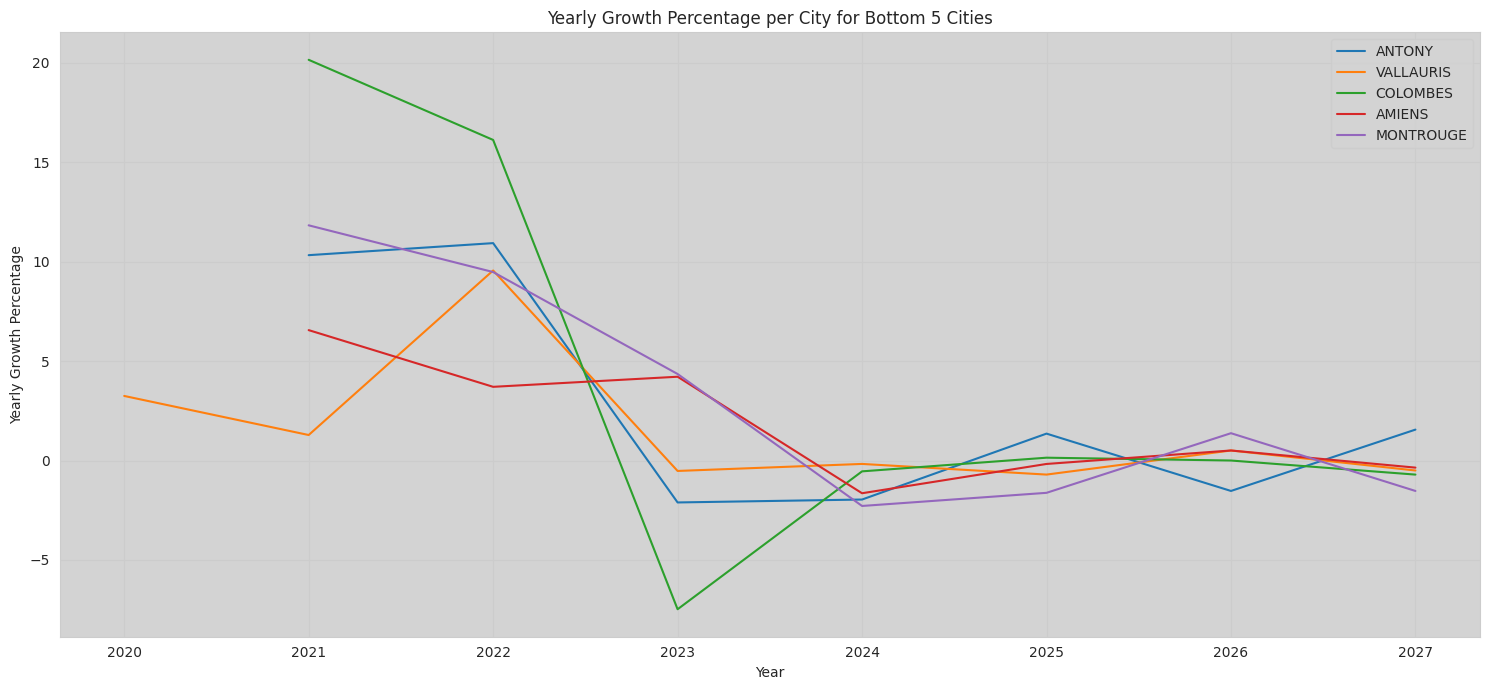

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ... [resto del código anterior] ...

# Convierte la columna 'Year' a int
df_ificom_clean_to_be_predictedV2['Year'] = df_ificom_clean_to_be_predictedV2['Year'].astype(int)

# Ordena el DataFrame por 'Commune_Code_INSEE' y 'Year'
df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.sort_values(by=['Commune_Code_INSEE', 'Year'])

# Obtén el valor del año anterior
df_ificom_clean_to_be_predictedV2['total_tax_per_city_lag1'] = df_ificom_clean_to_be_predictedV2.groupby('Commune_Code_INSEE')['total_tax_per_city'].shift(1)

# Calcula la tasa de crecimiento año tras año
df_ificom_clean_to_be_predictedV2['growth_percentage'] = ((df_ificom_clean_to_be_predictedV2['total_tax_per_city'] / df_ificom_clean_to_be_predictedV2['total_tax_per_city_lag1']) - 1) * 100

# ---- Gráfico para las ciudades con mayor crecimiento ----

# Filtramos el DataFrame para quedarnos sólo con las ciudades seleccionadas de top_5
df_selected_top = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(top_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in top_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_top[df_selected_top['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['growth_percentage'], label=city_name)

plt.title('Yearly Growth Percentage per City for Top 5 Cities')
plt.xlabel('Year')
plt.ylabel('Yearly Growth Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Gráfico para las ciudades con menor crecimiento ----

# Filtramos el DataFrame para quedarnos sólo con las ciudades seleccionadas de bottom_5
df_selected_bottom = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(bottom_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in bottom_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_bottom[df_selected_bottom['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['growth_percentage'], label=city_name)

plt.title('Yearly Growth Percentage per City for Bottom 5 Cities')
plt.xlabel('Year')
plt.ylabel('Yearly Growth Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


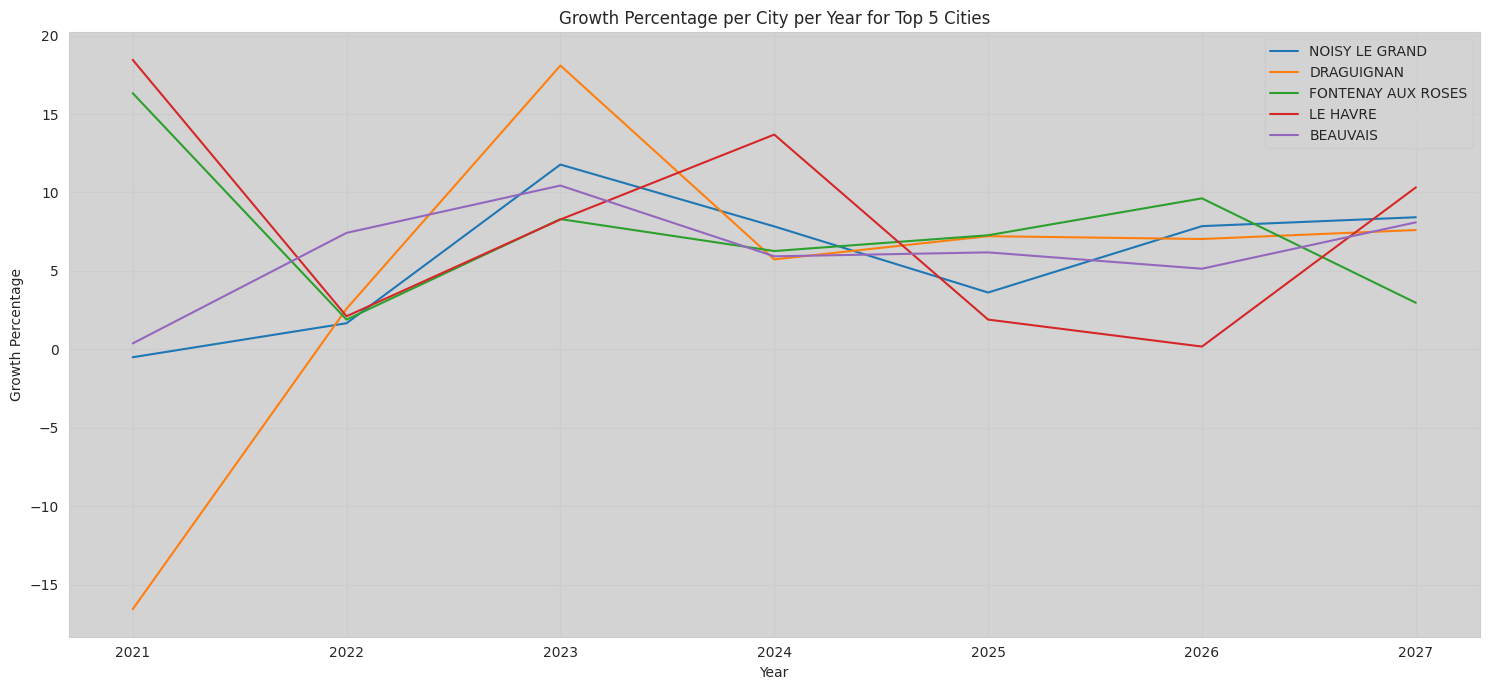

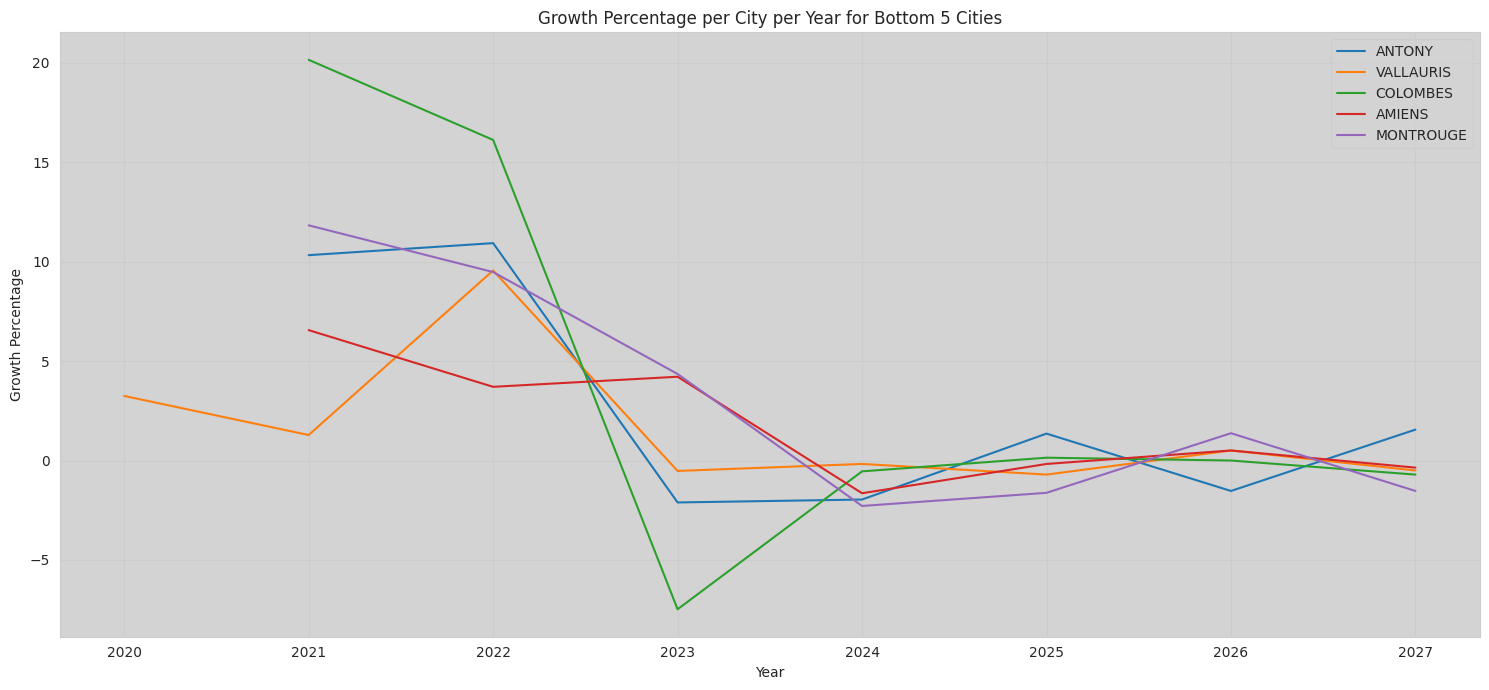

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ... [resto del código anterior] ...

# Convierte la columna 'Year' a int
df_ificom_clean_to_be_predictedV2['Year'] = df_ificom_clean_to_be_predictedV2['Year'].astype(int)

# Ordena el DataFrame por 'Commune_Code_INSEE' y 'Year'
df_ificom_clean_to_be_predictedV2 = df_ificom_clean_to_be_predictedV2.sort_values(by=['Commune_Code_INSEE', 'Year'])

# ---- Gráfico para las ciudades con mayor crecimiento ----

# Filtramos el DataFrame para quedarnos sólo con las ciudades seleccionadas de top_5
df_selected_top = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(top_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in top_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_top[df_selected_top['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['total_tax_per_city'], label=city_name)

plt.title('Yearly Total Tax per City for Top 5 Cities')
plt.xlabel('Year')
plt.ylabel('Total Tax per City')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Gráfico para las ciudades con menor crecimiento ----

# Filtramos el DataFrame para quedarnos sólo con las ciudades seleccionadas de bottom_5
df_selected_bottom = df_ificom_clean_to_be_predictedV2[df_ificom_clean_to_be_predictedV2['Commune_Code_INSEE'].isin(bottom_5_cities['Commune_Code_INSEE'])]

plt.figure(figsize=(15, 7))
for city_code in bottom_5_cities['Commune_Code_INSEE']:
    city_data = df_selected_bottom[df_selected_bottom['Commune_Code_INSEE'] == city_code]
    city_name = city_data['City'].iloc[0]
    plt.plot(city_data['Year'], city_data['total_tax_per_city'], label=city_name)

plt.title('Yearly Total Tax per City for Bottom 5 Cities')
plt.xlabel('Year')
plt.ylabel('Total Tax per City')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import folium
import pandas as pd
import geopandas as gpd

# [ ... ] Aquí va la preparación del DataFrame ...
# Asumiendo que ya tienes el DataFrame df_ificom_clean_to_be_predictedV2 cargado
df = df_ificom_clean_to_be_predictedV2.copy()

# Filtra solo el año 2020
df = df[df['Year'] == 2020.0]

# Excluye las ciudades donde Prophet == True
df = df[df['Prophet'] != True]

# Combina con average_growth_rates
df = pd.merge(df, average_growth_rates, on='Commune_Code_INSEE', how='left')

# Eliminar filas con valores NaN en las columnas 'latitude' y 'longitude'
df = df.dropna(subset=['latitude', 'longitude'])

# Ordenar el DataFrame según 'Yearly_Growth' y obtener los valores límite para el top 10 y flop 10
df = df.dropna(subset=['Yearly_Growth'])


sorted_df = df.sort_values(by='Yearly_Growth')
top_10_threshold = sorted_df['Yearly_Growth'].iloc[-10]
flop_10_threshold = sorted_df['Yearly_Growth'].iloc[9]


# Función para decidir el color de cada ciudad
def get_color(value):
    if value >= top_10_threshold:
        return 'green'
    elif value <= flop_10_threshold:
        return 'red'
    else:
        return 'orange'

# Read GeoJSON
PATH_IN_GEOJSON = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/Prediction_5Years_IFITAX/DataIn/'
geojson_data = gpd.read_file(PATH_IN_GEOJSON+'communes-avec-outre-mer.geojson')

# Simplify the GeoJSON data
simplified_geojson_data = geojson_data.copy()
simplified_geojson_data['geometry'] = simplified_geojson_data.geometry.simplify(tolerance=0.005)

# Calcula el valor promedio de Yearly_Growth para cada Commune_Code_INSEE
average_growth_by_commune = df.groupby('Commune_Code_INSEE')['Yearly_Growth'].mean()

def get_region_color(commune_code):
    # Asumiendo que average_growth_by_commune es una serie global
    if commune_code in average_growth_by_commune:
        return get_color(average_growth_by_commune[commune_code])
    else:
        return 'gray'  # color por defecto si no hay datos

# Crear un mapa centrado en Francia
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6, tiles="CartoDB positron")

folium.GeoJson(
    simplified_geojson_data,
    style_function=lambda feature: {
        'fillColor': get_region_color(feature['properties']['code']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }
).add_to(map_france)

# Añadir una leyenda
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 90px; background-color: rgba(255, 255, 255, 0.7); border:2px solid grey; z-index:9999; font-size:14px; border-radius: 6px;">
&nbsp;<b>Legend</b><br>
&nbsp;<i class="fa fa-square fa-1x" style="color:green"></i>&nbsp;Top 10<br>
&nbsp;<i class="fa fa-square fa-1x" style="color:orange"></i>&nbsp;Middle<br>
&nbsp;<i class="fa fa-square fa-1x" style="color:red"></i>&nbsp;Flop 10
</div>
"""
map_france.get_root().html.add_child(folium.Element(legend_html))

map_france.save("output_map.html")


In [ ]:
map_france


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
average_growth_rates

,Region,Department,Commune_Code_INSEE,City,Yearly_Growth
0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,3.492914
1,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06004,ANTIBES,3.242399
2,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06027,CAGNES SUR MER,1.671849
4,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06030,LE CANNET,2.223530
5,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06069,GRASSE,4.110102
...,...,...,...,...,...
202,ILE-DE-FRANCE,VAL-D'OISE,95428,MONTMORENCY,1.572065
205,LA REUNION,LA REUNION,97411,SAINT DENIS,0.842233
206,LA REUNION,LA REUNION,97415,SAINT PAUL,1.070352
207,LA REUNION,LA REUNION,97416,SAINT PIERRE,3.263020


In [ ]:
df

,Region,Department,Commune_Code_INSEE,City_x,Number_of_Taxpayers,Average_Assets_in_Euro,Average_Tax_in_Euro,Source_File,Year,latitude,longitude,total_tax_per_city,total_tax_per_city_lag1,mean,median,min,max,mean_distance_to_10_nearest,to_be_predicted,predicted,Prophet,City_y,Yearly_Growth
0,PROVENCE-ALPES-COTE D'AZUR,HAUTES-ALPES,05061,GAP,57.0,2224957.0,8488.0,ificom-2020.xlsx,2020.0,44.579860,6.064861,483816.0,535116.0,535116.0,535116.0,535116.0,535116.0,110.365115,False,False,NaN,GAP,3.492914
1,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06004,ANTIBES,407.0,2179041.0,8780.0,ificom-2020.xlsx,2020.0,43.587465,7.106354,3573460.0,3732322.0,3732322.0,3732322.0,3732322.0,3732322.0,12.740410,False,False,NaN,ANTIBES,3.242399
2,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06027,CAGNES SUR MER,154.0,2058262.0,8122.0,ificom-2020.xlsx,2020.0,43.671516,7.152757,1250788.0,1181619.0,1181619.0,1181619.0,1181619.0,1181619.0,15.516042,False,False,NaN,CAGNES SUR MER,1.671849
4,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06030,LE CANNET,158.0,2306599.0,9993.0,ificom-2020.xlsx,2020.0,43.572977,7.006421,1578894.0,1613358.0,1613358.0,1613358.0,1613358.0,1613358.0,11.210838,False,False,NaN,LE CANNET,2.223530
5,PROVENCE-ALPES-COTE D'AZUR,ALPES-MARITIMES,06069,GRASSE,126.0,2806244.0,18665.0,ificom-2020.xlsx,2020.0,43.655639,6.931905,2351790.0,1136088.0,1136088.0,1136088.0,1136088.0,1136088.0,16.085739,False,False,NaN,GRASSE,4.110102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,ILE-DE-FRANCE,VAL-D'OISE,95428,MONTMORENCY,117.0,2353003.0,11105.0,ificom-2020.xlsx,2020.0,48.991864,2.321198,1299285.0,NaN,NaN,NaN,NaN,NaN,9.754558,False,False,NaN,MONTMORENCY,1.572065
183,LA REUNION,LA REUNION,97411,SAINT DENIS,293.0,2383615.0,11004.0,ificom-2020.xlsx,2020.0,-20.932971,55.446867,3224172.0,NaN,NaN,NaN,NaN,NaN,6059.032062,False,False,NaN,SAINT DENIS,0.842233
184,LA REUNION,LA REUNION,97415,SAINT PAUL,175.0,2144491.0,8940.0,ificom-2020.xlsx,2020.0,-21.044532,55.322333,1564500.0,NaN,NaN,NaN,NaN,NaN,6060.240690,False,False,NaN,SAINT PAUL,1.070352
185,LA REUNION,LA REUNION,97416,SAINT PIERRE,111.0,2385917.0,11002.0,ificom-2020.xlsx,2020.0,-21.312324,55.493616,1221222.0,NaN,NaN,NaN,NaN,NaN,6084.981870,False,False,NaN,SAINT PIERRE,3.263020


In [ ]:
import folium
import pandas as pd
import branca
del df
# Asumiendo que ya tienes el DataFrame df_ificom_clean_to_be_predictedV2 cargado
df = df_ificom_clean_to_be_predictedV2.copy()

# Filtra solo el año 2020
df = df[df['Year'] == 2020.0]

# Excluye las ciudades donde Prophet == True
df = df[df['Prophet'] != True]

# Combina con average_growth_rates
df = pd.merge(df, average_growth_rates[['Commune_Code_INSEE', 'City', 'Yearly_Growth']], on='Commune_Code_INSEE', how='left')

# Eliminar filas con valores NaN en las columnas 'latitude', 'longitude', y 'Yearly_Growth'
df = df.dropna(subset=['latitude', 'longitude', 'Yearly_Growth'])

# Ordenar el DataFrame según 'Yearly_Growth' y obtener los valores límite para el top 10 y flop 10
sorted_df = df.sort_values(by='Yearly_Growth')
top_10_threshold = sorted_df['Yearly_Growth'].iloc[-10]
flop_10_threshold = sorted_df['Yearly_Growth'].iloc[9]

# Función para decidir el color de cada ciudad
def get_color(value):
    if value >= top_10_threshold:
        return 'green'
    elif value <= flop_10_threshold:
        return 'red'
    else:
        return 'orange'

# Crear un mapa centrado en Francia
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6)  # Coordenadas aproximadas del centro de Francia

# Añadir cada ciudad al mapa
for index, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    color = get_color(row['Yearly_Growth'])
    city_name = row['City_x']  # Usamos la columna 'City' aquí

    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_opacity=0.6,
        fill_color=color,
        tooltip=f"{city_name}: {row['Yearly_Growth']}%"
    ).add_to(map_france)

map_france


In [ ]:
import folium
import pandas as pd
import numpy as np

# ... [resto del código anterior] ...

# Determinar los umbrales para diferentes rangos
sorted_df = df.sort_values(by='Yearly_Growth')
percentiles = sorted_df['Yearly_Growth'].quantile([0.1, 0.3, 0.5, 0.7, 0.9])

# Función para decidir el color de cada ciudad
def get_color(value):
    if value >= percentiles[0.9]:
        return '#008000'  # verde para el top 10%
    elif value >= percentiles[0.7]:
        return '#ADFF2F'  # verde amarillento para el siguiente 20%
    elif value >= percentiles[0.5]:
        return '#FFFF00'  # amarillo para el medio 20%
    elif value >= percentiles[0.3]:
        return '#FFA500'  # naranja para el siguiente 20%
    else:
        return '#FF0000'  # rojo para el flop 10%

# Función para decidir el radio de cada ciudad
def get_radius(value):
    return value * 200  # Ajusta el factor 200 según sea necesario

# Crear un mapa centrado en Francia con el estilo CartoDB dark_matter
map_france = folium.Map(location=[46.603354, 1.888334], zoom_start=6, tiles='CartoDB dark_matter')

# Añadir cada ciudad al mapa
for index, row in df.iterrows():
    lat, lon = row['latitude'], row['longitude']
    color = get_color(row['Yearly_Growth'])
    radius = get_radius(row['Yearly_Growth'])
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fill_opacity=0.6,
        fill_color=color,
        tooltip=f"{row['City_x']}: {int(row['Yearly_Growth'] * 100)}%"
    ).add_to(map_france)

map_france


#Cleaning data for Data Viz


In [ ]:
PATH_OUT_PowerBI = '/content/drive/MyDrive/Godi.AI/Operations/Freelancer/Projets/Impots_sur_la_fortune/Prediction_5Years_IFITAX/Dataout/PowerBI'


#Guardando un df con la informacion estatica
df_ificom_clean_to_be_predictedV2[['Region', 'Department','Commune_Code_INSEE', 'City','latitude','longitude']].to_csv(PATH_OUT_PowerBI+"/static_df.csv")






In [ ]:
#guardando informacion que cambia
df_ificom_clean_to_be_predictedV2[[ 'Commune_Code_INSEE','Number_of_Taxpayers', 'Average_Assets_in_Euro', 'Average_Tax_in_Euro',
                                                              'Source_File', 'Year', 'total_tax_per_city',
                                                              'total_tax_per_city_lag1', 'mean', 'median', 'min', 'max',
                                                              'mean_distance_to_10_nearest', 'to_be_predicted', 'predicted',
                                                              'Prophet']].to_csv(PATH_OUT_PowerBI+"/df_ificom_generated_data.csv")

In [ ]:
#Guardando informacion calculada
average_growth_rates.to_csv(PATH_OUT_PowerBI+"/average_growth_rates.csv")

In [ ]:
pd.DataFrame(top_5_cities).to_csv(PATH_OUT_PowerBI+"/top_5_cities.csv")
bottom_5_cities.to_csv(PATH_OUT_PowerBI+"/bottom_5_cities.csv")